In [1]:
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from optuna.integration import OptunaSearchCV
from scipy.stats import randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, make_scorer,
                             mean_absolute_error, mean_squared_error,
                             precision_score, recall_score, r2_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder,
                                   StandardScaler)
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [2]:
df = pd.read_csv('train.csv')
df.head(10)

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate
5,5,1,39,1,171,1,19,133.1,1,19,...,0,0,0,0,0.000000,0,13.9,-0.3,0.79,Dropout
6,6,1,44,1,9085,1,39,130.0,1,37,...,0,5,8,5,13.250000,0,12.4,0.5,1.79,Graduate
7,7,1,1,1,9773,1,1,130.0,1,19,...,0,6,6,6,13.666667,0,10.8,1.4,1.74,Graduate
8,8,1,39,1,9003,1,1,133.1,1,19,...,0,6,10,0,0.000000,0,16.2,0.3,-0.92,Dropout
9,9,1,1,6,9500,1,1,135.0,1,37,...,0,7,7,6,12.966667,0,7.6,2.6,0.32,Graduate


In [3]:
# 3. Общая информация о данных
print("Информация о данных:")
print(df.info())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualifica

### Проверка на пропуски

In [4]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Пропуски': missing, 'Процент': missing_percent})
missing_df = missing_df[missing_df['Пропуски'] > 0].sort_values(by='Пропуски', ascending=False)

if missing_df.empty:
    print("Пропущенных значений нет.")
else:
    print("Пропущенные значения:")
    print(missing_df)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_df.index, y=missing_df['Процент'])
    plt.xticks(rotation=90)
    plt.title('Процент пропусков по признакам')
    plt.show()

Пропущенных значений нет.


### Целевая переменная

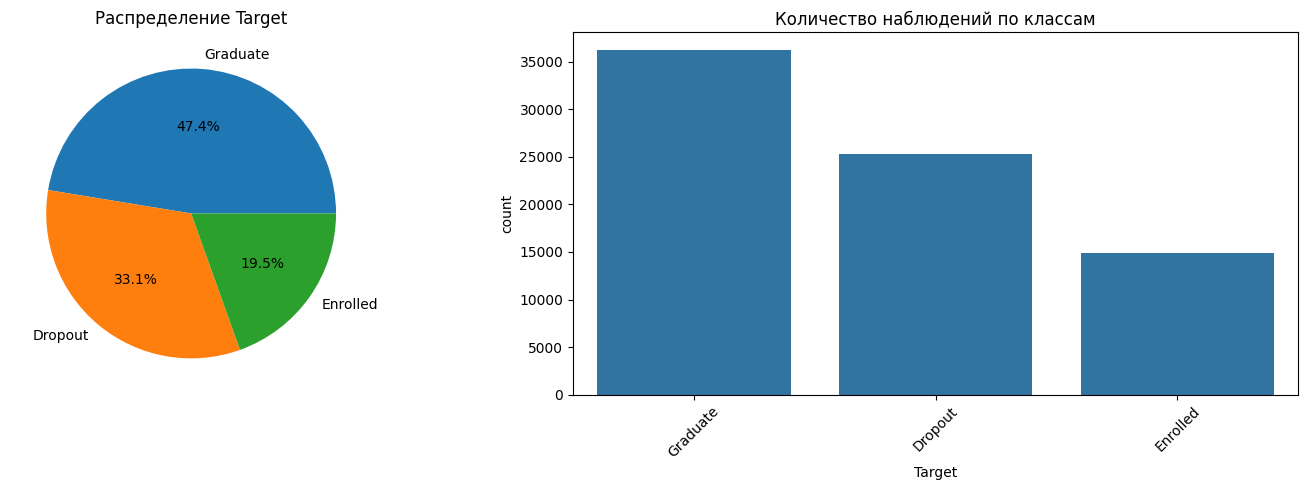

Распределение классов:
Target
Graduate    36282
Dropout     25296
Enrolled    14940
Name: count, dtype: int64

Graduate: Успешно окончил учебное заведение.
Dropout: Отчислен (прервал обучение).
Enrolled: Все еще учится (на момент сбора данных).


In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
target_counts = df['Target'].value_counts()
plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%')
plt.title('Распределение Target')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Target')
plt.title('Количество наблюдений по классам')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Распределение классов:")
print(target_counts)
print('\nGraduate: Успешно окончил учебное заведение.')
print('Dropout: Отчислен (прервал обучение).')
print('Enrolled: Все еще учится (на момент сбора данных).')

### Корреляционный анализ

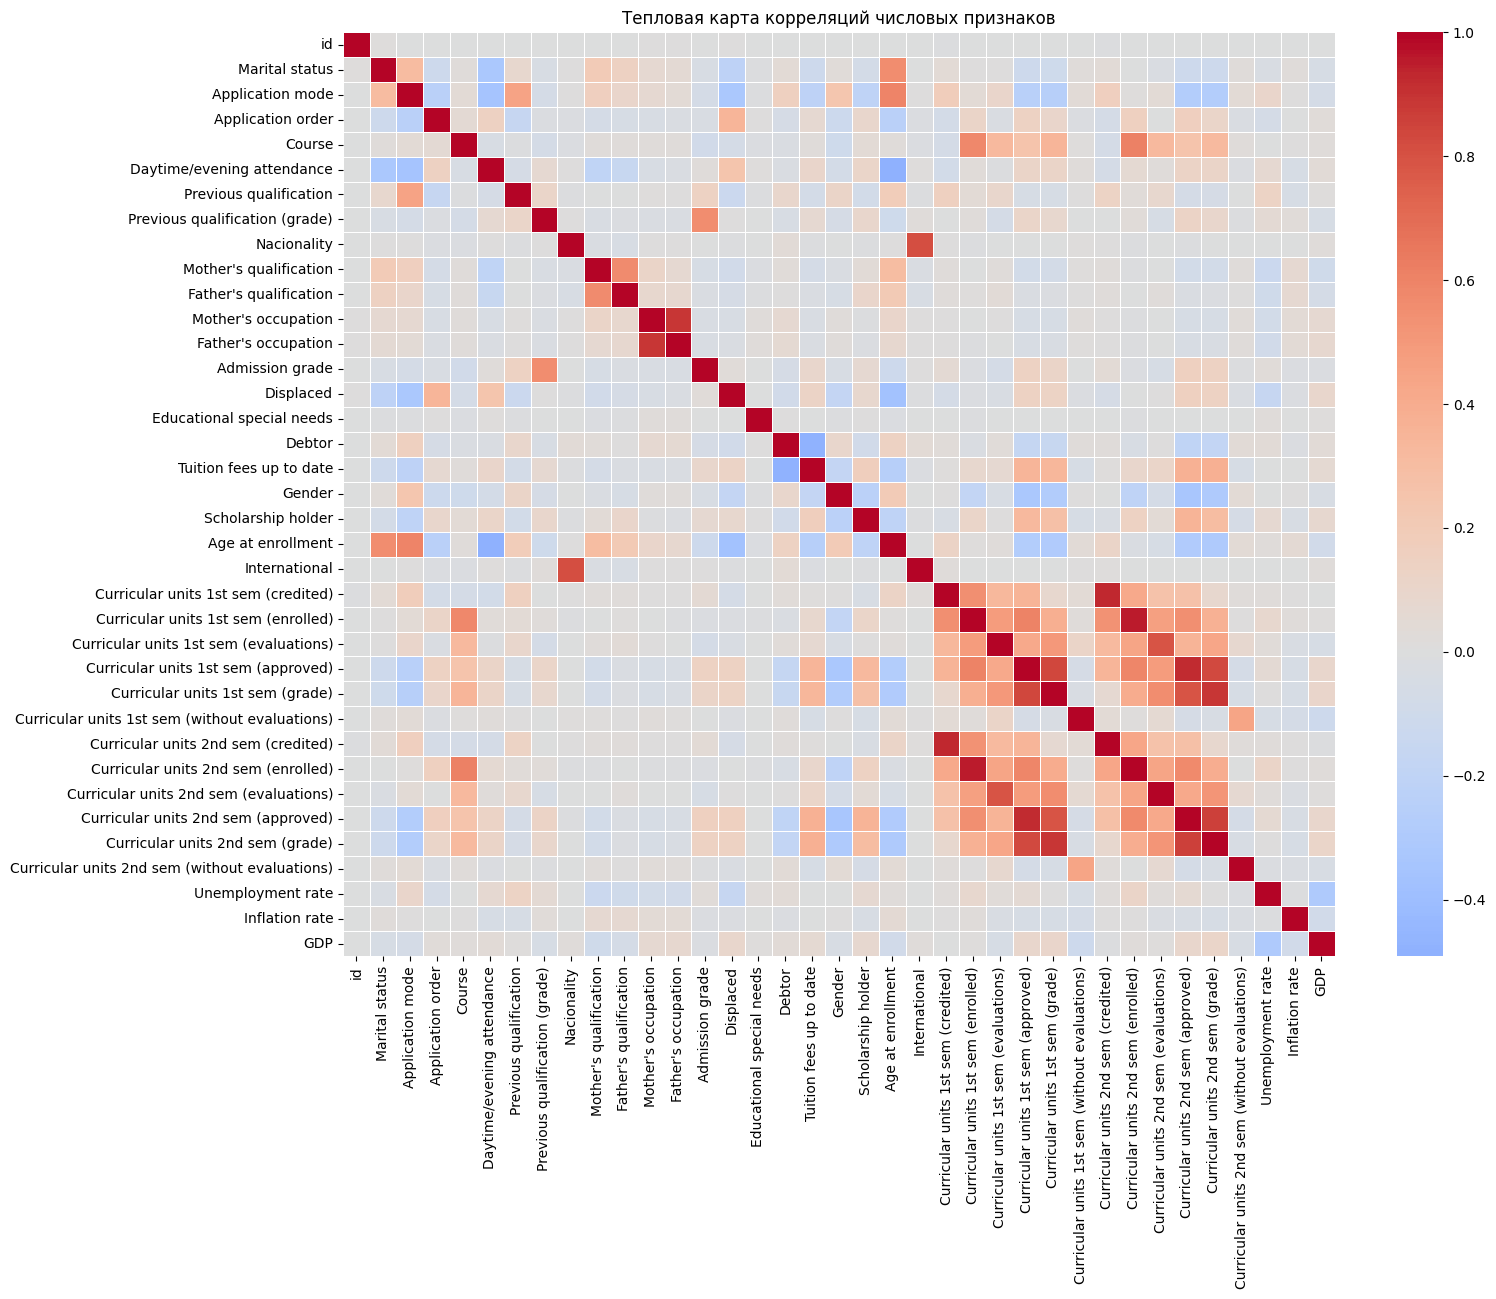

Высококоррелированные пары признаков (|corr| > 0.8):
Nacionality — International: 0.817
Mother's occupation — Father's occupation: 0.895
Curricular units 1st sem (credited) — Curricular units 2nd sem (credited): 0.934
Curricular units 1st sem (enrolled) — Curricular units 2nd sem (enrolled): 0.956
Curricular units 1st sem (approved) — Curricular units 1st sem (grade): 0.840
Curricular units 1st sem (approved) — Curricular units 2nd sem (approved): 0.923
Curricular units 1st sem (approved) — Curricular units 2nd sem (grade): 0.830
Curricular units 1st sem (grade) — Curricular units 2nd sem (grade): 0.889
Curricular units 2nd sem (approved) — Curricular units 2nd sem (grade): 0.859


In [6]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Тепловая карта корреляций числовых признаков')
plt.show()

# Высококоррелированные признаки (коэффициент > 0.8 или < -0.8)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr:
    print("Высококоррелированные пары признаков (|corr| > 0.8):")
    for pair in high_corr:
        print(f"{pair[0]} — {pair[1]}: {pair[2]:.3f}")
else:
    print("Нет сильно коррелирующих пар признаков (|corr| > 0.8).")

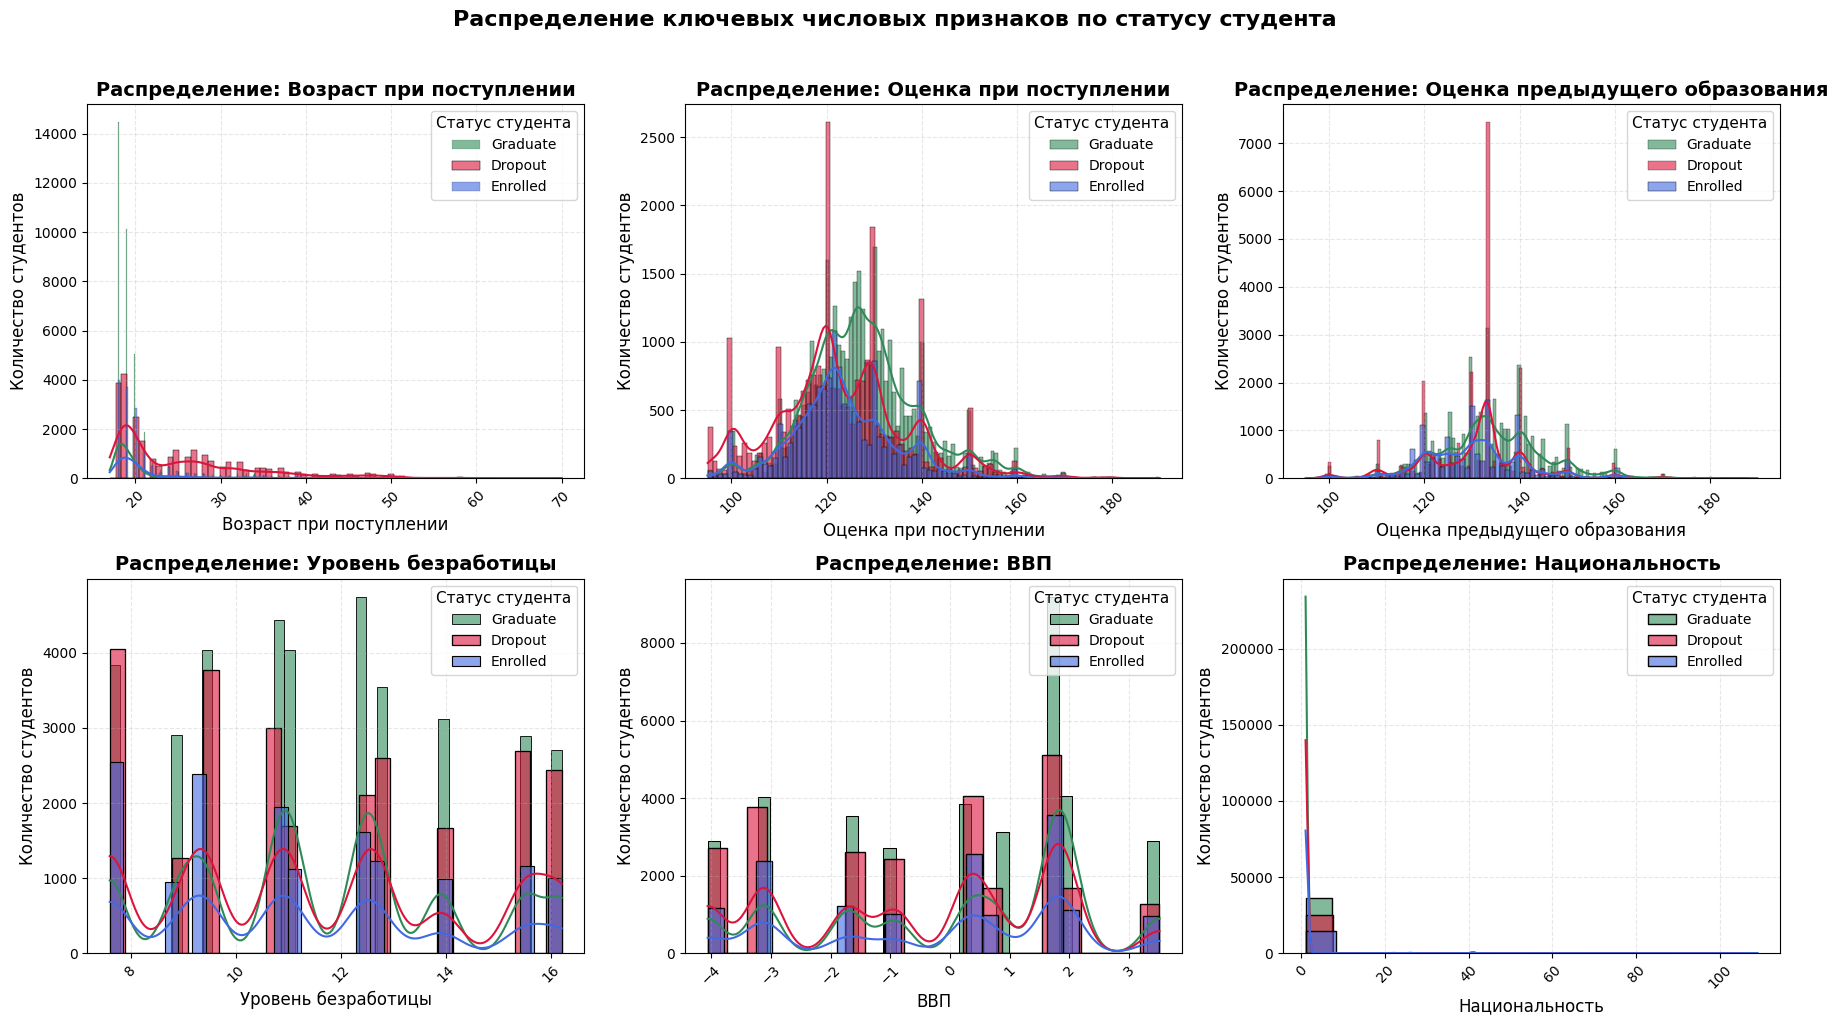

In [33]:
# Словарь для перевода названий признаков
feature_translation = {
    'Age at enrollment': 'Возраст при поступлении',
    'Admission grade': 'Оценка при поступлении',
    'Previous qualification (grade)': 'Оценка предыдущего образования',
    'Unemployment rate': 'Уровень безработицы',
    'GDP': 'ВВП',
    'Nacionality': 'Национальность'
}

# Цвета для классов Target
target_colors = {
    'Graduate': '#2E8B57',  # Зеленый
    'Dropout': '#DC143C',   # Красный
    'Enrolled': '#4169E1'   # Синий
}

key_numeric = ['Age at enrollment', 'Admission grade', 
               'Previous qualification (grade)', 'Unemployment rate', 'GDP', 'Nacionality']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

plt.rcParams['font.family'] = 'DejaVu Sans' 

for i, col in enumerate(key_numeric[:6]):
    ax = axes[i]
    
    for target_class in df['Target'].unique():
        subset = df[df['Target'] == target_class]
        sns.histplot(data=subset, x=col, kde=True, 
                     color=target_colors[target_class], 
                     label=target_class, alpha=0.6, ax=ax)
    
    russian_title = feature_translation.get(col, col)
    ax.set_title(f'Распределение: {russian_title}', fontsize=14, fontweight='bold')
    ax.set_xlabel(russian_title, fontsize=12)
    ax.set_ylabel('Количество студентов', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    ax.legend(title='Статус студента', title_fontsize=11, fontsize=10,
              loc='upper right' if i != 0 else 'upper right')
    
    ax.grid(True, alpha=0.3, linestyle='--')

for i in range(len(key_numeric), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Распределение ключевых числовых признаков по статусу студента', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


C:\Users\Админ\AppData\Local\Temp\ipykernel_25856\3454966192.py:59: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  bars = sns.barplot(data=temp_df, x='category_label', y='dropout_rate',
C:\Users\Админ\AppData\Local\Temp\ipykernel_25856\3454966192.py:59: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  bars = sns.barplot(data=temp_df, x='category_label', y='dropout_rate',
C:\Users\Админ\AppData\Local\Temp\ipykernel_25856\3454966192.py:59: UserWarning: 
The palette list has fewer values (1) than needed (39) and will cycle, which may produce an uninterpretable plot.
  bars = sns.barplot(data=temp_df, x='category_label', y='dropout_rate',
C:\Users\Админ\AppData\Local\Temp\ipykernel_25856\3454966192.py:59: UserWarning: 
The palette list has fewer values (1) than needed (35) and will cycle, which may produce an uninterpretable plot.

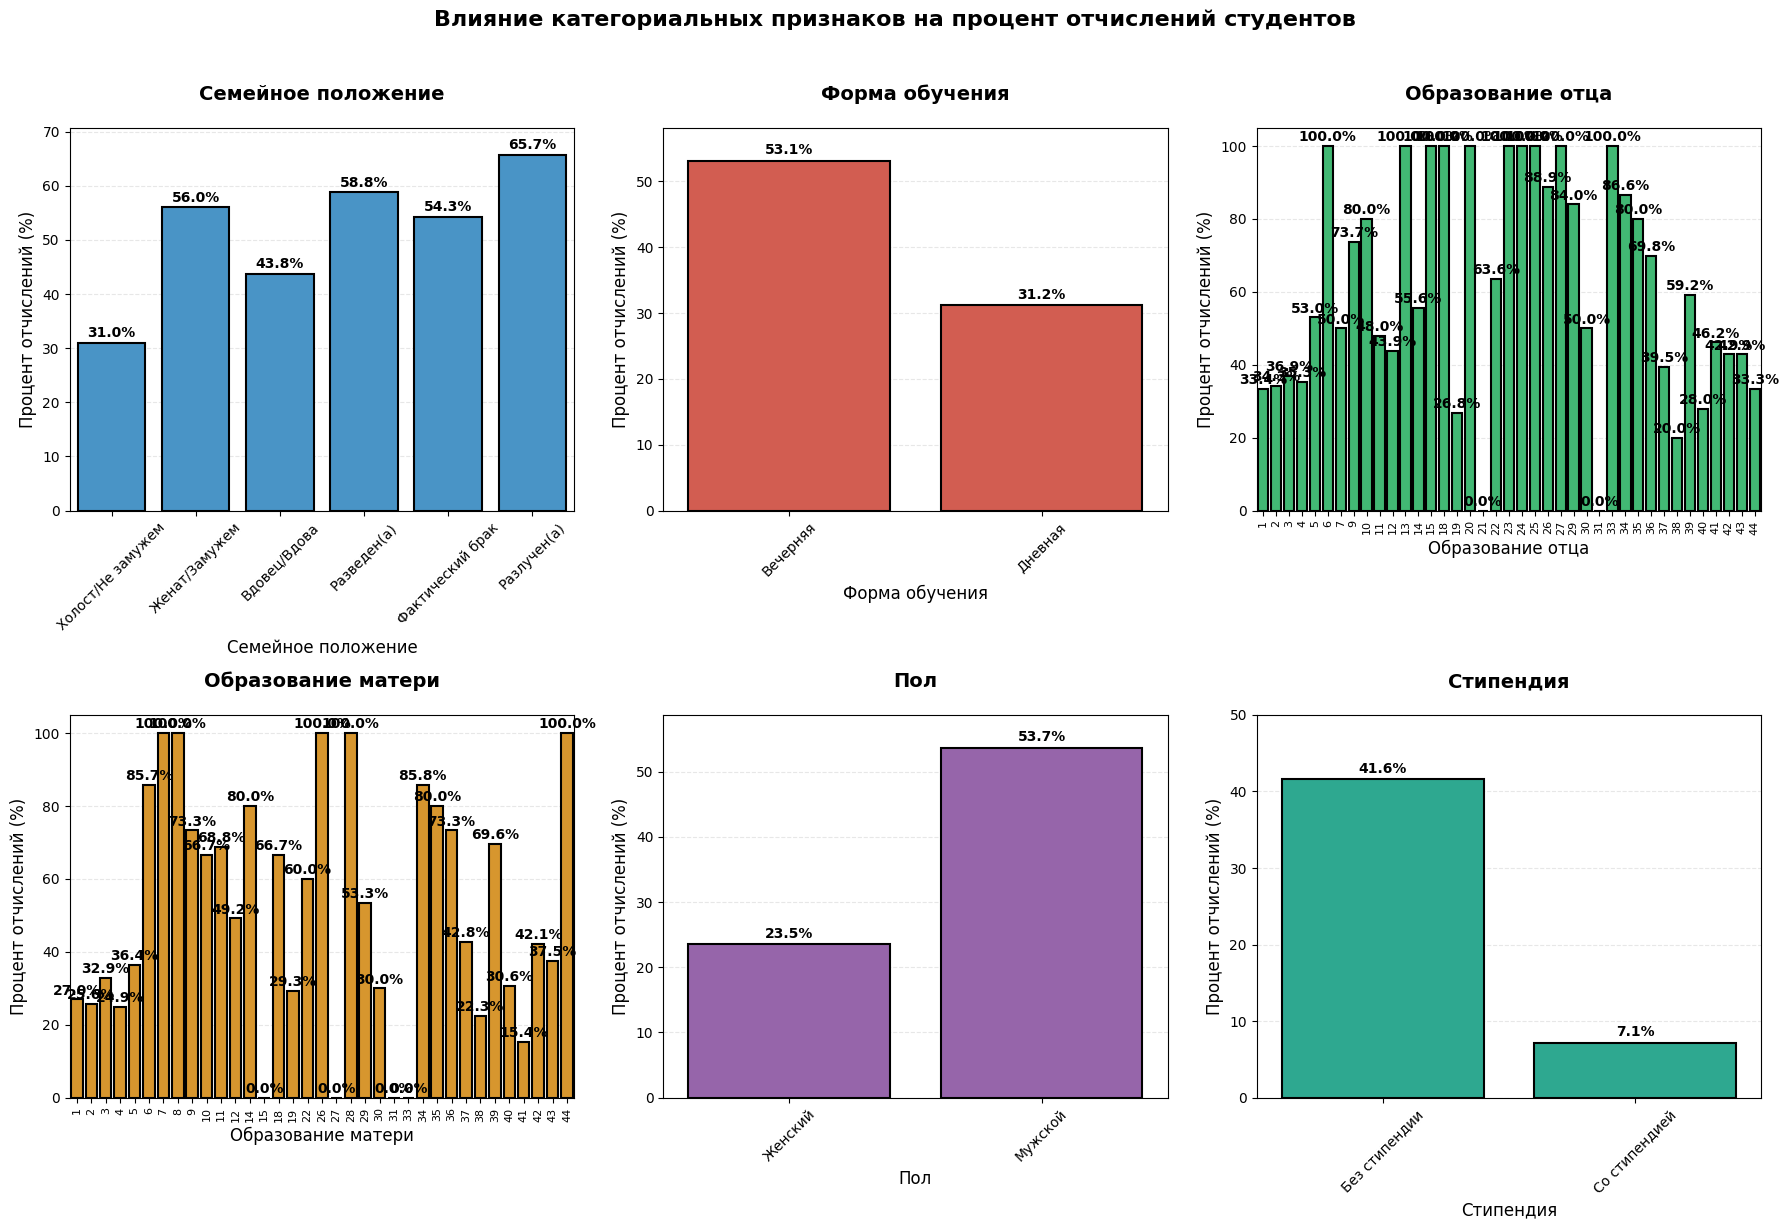

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Словарь для перевода названий признаков
feature_translation = {
    'Marital status': 'Семейное положение',
    'Daytime/evening attendance': 'Форма обучения',
    'Father\'s qualification': 'Образование отца',
    'Mother\'s qualification': 'Образование матери',
    'Gender': 'Пол',
    'Scholarship holder': 'Стипендия'
}

# Словари для перевода значений категорий
category_translation = {
    'Marital status': {
        1: 'Холост/Не замужем',
        2: 'Женат/Замужем',
        3: 'Вдовец/Вдова',
        4: 'Разведен(а)',
        5: 'Фактический брак',
        6: 'Разлучен(а)'
    },
    'Daytime/evening attendance': {
        1: 'Дневная',
        0: 'Вечерняя'
    },
    'Gender': {
        1: 'Мужской',
        0: 'Женский'
    },
    'Scholarship holder': {
        1: 'Со стипендией',
        0: 'Без стипендии'
    }
}

cat_features = ['Marital status', 'Daytime/evening attendance', 
                'Father\'s qualification', 'Mother\'s qualification',
                'Gender', 'Scholarship holder']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for i, col in enumerate(cat_features):
    temp_df = df.groupby(col)['Target'].apply(
        lambda x: (x == 'Dropout').mean() * 100
    ).reset_index(name='dropout_rate')
    
    russian_title = feature_translation.get(col, col)
    
    if col in category_translation:
        temp_df['category_label'] = temp_df[col].map(category_translation[col])
    else:
        temp_df['category_label'] = temp_df[col].astype(str)
    
    bars = sns.barplot(data=temp_df, x='category_label', y='dropout_rate', 
                       hue='category_label', 
                       legend=False, 
                       ax=axes[i], 
                       palette=[colors[i % len(colors)]],  
                       edgecolor='black', linewidth=1.5)
    
    axes[i].set_title(f'{russian_title}', 
                      fontsize=14, fontweight='bold', pad=20)
    axes[i].set_xlabel(russian_title, fontsize=12)
    axes[i].set_ylabel('Процент отчислений (%)', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)
    
    for idx, p in enumerate(bars.patches):
        height = p.get_height()
        axes[i].text(p.get_x() + p.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')

    axes[i].grid(True, alpha=0.3, linestyle='--', axis='y')
    axes[i].set_axisbelow(True)
    
    axes[i].set_ylim(0, max(temp_df['dropout_rate'].max() + 5, 50))
    
    if col in ['Father\'s qualification', 'Mother\'s qualification']:
        axes[i].tick_params(axis='x', rotation=90, labelsize=8)

plt.suptitle('Влияние категориальных признаков на процент отчислений студентов', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Очистка данных

## Укрупнение категориальных данных

In [3]:
train = pd.read_csv('train.csv')

In [4]:
pd.set_option('display.max_columns', None)
train.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,18,0,0,6,6,6,14.500000,0,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,18,0,0,6,8,4,11.600000,0,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,19,2,3,144.7,0,0,0,1,1,0,18,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,3,3,2,126.1,1,0,0,1,0,1,18,0,0,7,9,7,12.591250,0,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,37,4,9,120.1,1,0,0,1,0,0,18,0,0,7,12,6,12.933333,0,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

In [6]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 22.18 MB
Memory usage after optimization is: 4.23 MB
Decreased by 80.9%


In [7]:
nationality_region_mapping = {
    # Западная Европа
    2: 1,   # German
    13: 1,  # Dutch
    14: 1,  # English
    # Южная Европа
    1: 2,  # Portuguese
    6: 2,  # Spanish
    11: 2, # Italian
    62: 2, # Romanian
    # Восточная Европа
    17: 3,  # Lithuanian
    100: 3, # Moldova
    103: 3, # Ukrainian
    105: 3, # Russian
    # Африка
    21: 4,  # Angolan
    22: 4,  # Cape Verdean
    24: 4,  # Guinean
    25: 4,  # Mozambican
    26: 4,  # Santomean
    # Латинская Америка
    41: 5,  # Brazilian
    101: 5, # Mexican
    108: 5, # Cuban
    109: 5, # Colombian
    # Азия
    32: 6  # Turkish
}

In [8]:
train['Nationality_Region'] = train['Nacionality'].map(nationality_region_mapping)

In [9]:
train = train.drop('id', axis=1)

In [10]:
label_encoder = LabelEncoder()
train['target_encoded'] = label_encoder.fit_transform(train['Target'])

print("Соответствие классов:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i} -> {class_name}")

Соответствие классов:
0 -> Dropout
1 -> Enrolled
2 -> Graduate


In [11]:
train = train.drop('Nacionality', axis=1)

In [12]:
train_wout_2nd_sem = train.loc[:, ~train.columns.str.contains('2nd sem', case=False, na=False)]
train_wout_2nd_sem = train_wout_2nd_sem[train_wout_2nd_sem['Target'] != 'Enrolled']
train_wout_2nd_sem['target_encoded'] = train_wout_2nd_sem['target_encoded'].replace(2, 1)

In [13]:
train_wout_2nd_sem

C:\Users\Данил\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Nationality_Region,target_encoded
0,1,1,1,9238,1,1,126.000,1,19,5,5,122.6250,0,0,0,1,0,1,18,0,0,6,6,6,14.500000,0,11.101562,0.600098,2.019531,Graduate,2,1
1,1,17,1,9238,1,1,125.000,19,19,9,9,119.8125,1,0,0,1,0,0,18,0,0,6,8,4,11.601562,0,11.101562,0.600098,2.019531,Dropout,2,0
2,1,17,2,9254,1,1,137.000,3,19,2,3,144.7500,0,0,0,1,1,0,18,0,0,6,0,0,0.000000,0,16.203125,0.300049,-0.919922,Dropout,2,0
4,1,1,2,9500,1,1,132.000,19,37,4,9,120.1250,1,0,0,1,0,0,18,0,0,7,12,6,12.929688,0,7.601562,2.599609,0.320068,Graduate,2,1
5,1,39,1,171,1,19,133.125,19,19,1,1,100.0000,0,0,0,1,1,0,24,0,0,0,0,0,0.000000,0,13.898438,-0.300049,0.790039,Dropout,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76512,1,1,1,9238,1,1,134.000,19,38,4,7,122.1250,1,0,0,1,0,0,19,0,0,6,6,6,12.664062,0,7.601562,2.599609,0.320068,Graduate,2,1
76513,1,17,1,9254,1,1,121.000,19,1,7,5,116.5000,1,0,0,1,0,1,18,0,0,6,9,6,10.664062,0,13.898438,-0.300049,0.790039,Graduate,2,1
76514,1,1,6,9254,1,1,125.000,1,38,4,9,131.6250,1,0,0,1,0,0,19,0,0,6,22,4,13.000000,0,9.398438,-0.799805,-3.119141,Graduate,2,1
76516,1,1,3,9070,1,1,136.000,38,37,5,9,124.8125,1,0,0,1,0,0,18,0,0,6,0,0,0.000000,0,7.601562,2.599609,0.320068,Dropout,2,0


In [14]:
df = train_wout_2nd_sem.copy()

# 1. Application mode (Режим поступления)
def group_application_mode(x):
    if x in [1, 17, 18]:
        return 1  # Общий конкурс
    elif x in [5, 16, 26, 44, 53]:
        return 2  # Специальные квоты
    elif x in [2, 10, 27, 39, 42, 43, 51, 57]:
        return 3  # Другие формы доступа
    elif x == 15:
        return 4  # Международные
    elif x == 7:
        return 5  # Другие высшие курсы
    else:
        return x  # Оставляем как есть, если код не распознан

df['Application_mode_grouped'] = df['Application mode'].apply(group_application_mode)

# 2. Course (Курс)
def group_course(x):
    # Инженерия и IT
    if x in [9119, 9130]:
        return 1
    # Здравоохранение
    elif x in [9085, 9500, 9556]:
        return 2
    # Бизнес и управление
    elif x in [9147, 9670, 9991]:
        return 3
    # Сельское хозяйство и природа
    elif x in [9003, 33]:
        return 4
    # Социальные науки и сервис
    elif x in [8014, 9238, 9254, 9773, 9853]:
        return 5
    # Дизайн и искусство
    elif x in [171, 9070]:
        return 6
    else:
        return x  # Оставляем как есть

df['Course_grouped'] = df['Course'].apply(group_course)

# 3. Previous qualification (Предыдущее образование)
def group_qualification(x):
    # Без образования/Начальное
    if x in [9, 10, 11, 12, 14, 15, 18, 26, 27, 29, 30, 34, 35, 36, 37, 38]:
        return 1
    # Среднее образование/Профессиональное
    elif x in [1, 19, 39, 42]:
        return 2
    # Неоконченное высшее
    elif x == 6:
        return 3
    # Высшее (1-й цикл / бакалавриат)
    elif x in [2, 3, 40]:
        return 4
    # Высшее (2-й цикл и выше / магистратура+)
    elif x in [4, 5, 41, 43, 44]:
        return 5
    else:
        return 0  # Неизвестно/Пропущено

df['Previous_qualification_grouped'] = df['Previous qualification'].apply(group_qualification)

# 4. Mother's qualification (Образование матери)
def group_mother_qualification(x):
    # Без образования/Начальное
    if x in [9, 10, 11, 12, 14, 18, 26, 27, 29, 30, 34, 35, 36, 37, 38]:
        return 1
    # Среднее образование/Профессиональное
    elif x in [1, 19, 22, 39, 42]:
        return 2
    # Неоконченное высшее
    elif x == 6:
        return 3
    # Высшее (1-й цикл / бакалавриат)
    elif x in [2, 3, 40, 41]:
        return 4
    # Высшее (2-й цикл и выше / магистратура+)
    elif x in [4, 5, 43, 44]:
        return 5
    else:
        return 0  # Неизвестно/Пропущено

df['Mother_qualification_grouped'] = df["Mother's qualification"].apply(group_mother_qualification)

# 5. Father's qualification (Образование отца)
def group_father_qualification(x):
    # Без образования/Начальное
    if x in [9, 10, 11, 12, 13, 14, 18, 20, 22, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38]:
        return 1
    # Среднее образование/Профессиональное
    elif x in [1, 19, 39, 42]:
        return 2
    # Неоконченное высшее
    elif x == 6:
        return 3
    # Высшее (1-й цикл / бакалавриат)
    elif x in [2, 3, 40, 41]:
        return 4
    # Высшее (2-й цикл и выше / магистратура+)
    elif x in [4, 5, 43, 44]:
        return 5
    else:
        return 0  # Неизвестно/Пропущено

df['Father_qualification_grouped'] = df["Father's qualification"].apply(group_father_qualification)

# 6. Mother's occupation (Профессия матери)
def group_mother_occupation(x):
    # Руководители и управленцы
    if x in [0, 1]:
        return 1
    # Специалисты высшего уровня
    elif x in [2, 122, 123, 125]:
        return 2
    # Специалисты среднего уровня/Техники
    elif x in [3, 131, 132, 134]:
        return 3
    # Служащие/Административный персонал
    elif x in [4, 141, 143, 144]:
        return 4
    # Работники сферы услуг и торговли
    elif x in [5, 151, 152, 153]:
        return 5
    # Квалифицированные рабочие
    elif x in [6, 7, 8, 171, 173, 175]:
        return 6
    # Неквалифицированные рабочие
    elif x in [9, 191, 192, 193, 194]:
        return 7
    # Силовые структуры
    elif x == 10:
        return 8
    else:
        return 0  # Другое/Неизвестно (90, 99)

df['Mother_occupation_grouped'] = df["Mother's occupation"].apply(group_mother_occupation)

# 7. Father's occupation (Профессия отца)
def group_father_occupation(x):
    # Руководители и управленцы
    if x in [0, 1, 101, 102, 112, 114]:
        return 1
    # Специалисты высшего уровня
    elif x in [2, 121, 122, 123, 124]:
        return 2
    # Специалисты среднего уровня/Техники
    elif x in [3, 103, 131, 132, 134, 135]:
        return 3
    # Служащие/Административный персонал
    elif x in [4, 141, 143, 144]:
        return 4
    # Работники сферы услуг и торговли
    elif x in [5, 151, 152, 153, 154, 161, 163, 182, 183, 194, 195]:
        return 5
    # Квалифицированные рабочие
    elif x in [6, 7, 8, 171, 172, 174, 175, 181]:
        return 6
    # Неквалифицированные рабочие
    elif x in [9, 191, 192, 193]:
        return 7
    # Силовые структуры
    elif x == 10:
        return 8
    else:
        return 0  # Другое/Неизвестно (90, 99)

df['Father_occupation_grouped'] = df["Father's occupation"].apply(group_father_occupation)

# 8. Marital Status (Семейное положение)
def group_marital_status(x):
    # Не в отношениях (холост)
    if x == 1:
        return 1
    # В официальных отношениях (женат/замужем)
    elif x == 2:
        return 2
    # В неофициальных отношениях
    elif x == 5:
        return 3
    # Ранее состоял в отношениях (вдовец/разведен/раздельно)
    elif x in [3, 4, 6]:
        return 4
    else:
        return x

df['Marital_status_grouped'] = df['Marital status'].apply(group_marital_status)

In [15]:
columns_to_drop = [
    'Application mode', 'Course', 'Previous qualification',
    "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation", 'Marital status'
]
df = df.drop(columns=columns_to_drop)

In [16]:
df

C:\Users\Данил\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Application order,Daytime/evening attendance,Previous qualification (grade),Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Nationality_Region,target_encoded,Application_mode_grouped,Course_grouped,Previous_qualification_grouped,Mother_qualification_grouped,Father_qualification_grouped,Mother_occupation_grouped,Father_occupation_grouped,Marital_status_grouped
0,1,1,126.000,122.6250,0,0,0,1,0,1,18,0,0,6,6,6,14.500000,0,11.101562,0.600098,2.019531,Graduate,2,1,1,5,2,2,2,5,5,1
1,1,1,125.000,119.8125,1,0,0,1,0,0,18,0,0,6,8,4,11.601562,0,11.101562,0.600098,2.019531,Dropout,2,0,1,5,2,2,2,7,7,1
2,2,1,137.000,144.7500,0,0,0,1,1,0,18,0,0,6,0,0,0.000000,0,16.203125,0.300049,-0.919922,Dropout,2,0,1,5,2,4,2,2,3,1
4,2,1,132.000,120.1250,1,0,0,1,0,0,18,0,0,7,12,6,12.929688,0,7.601562,2.599609,0.320068,Graduate,2,1,1,2,2,2,1,4,7,1
5,1,1,133.125,100.0000,0,0,0,1,1,0,24,0,0,0,0,0,0.000000,0,13.898438,-0.300049,0.790039,Dropout,2,0,3,6,2,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76512,1,1,134.000,122.1250,1,0,0,1,0,0,19,0,0,6,6,6,12.664062,0,7.601562,2.599609,0.320068,Graduate,2,1,1,5,2,2,1,4,6,1
76513,1,1,121.000,116.5000,1,0,0,1,0,1,18,0,0,6,9,6,10.664062,0,13.898438,-0.300049,0.790039,Graduate,2,1,1,5,2,2,2,6,5,1
76514,6,1,125.000,131.6250,1,0,0,1,0,0,19,0,0,6,22,4,13.000000,0,9.398438,-0.799805,-3.119141,Graduate,2,1,1,5,2,2,1,4,7,1
76516,3,1,136.000,124.8125,1,0,0,1,0,0,18,0,0,6,0,0,0.000000,0,7.601562,2.599609,0.320068,Dropout,2,0,1,6,2,1,1,5,7,1


## Убираем с оценками = 0 за первый семестр

In [17]:
target_distribution = df[df['Curricular units 1st sem (approved)'] == 0]['Target'].value_counts()

In [18]:
target_distribution

Target
Dropout     14854
Graduate      549
Name: count, dtype: int64

In [19]:
df = df[df['Curricular units 1st sem (approved)'] > 0]

# Логистическая регрессия на очищенных данных

In [20]:
df_t = df.copy()

In [21]:
if 'target_encoded' not in df_t.columns:
    le = LabelEncoder()
    df_t['target_encoded'] = le.fit_transform(df_t['Target'])
    print(f"Target classes mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

In [22]:
X = df_t.drop(['Target', 'target_encoded'], axis=1, errors='ignore')
y = df_t['target_encoded'] if 'target_encoded' in df_t.columns else le.transform(df['Target'])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
numeric_features = [
    'Application order',
    'Previous qualification (grade)',
    'Admission grade',
    'Age at enrollment',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Unemployment rate',
    'Inflation rate',
    'GDP'
]

binary_features = [
    'Daytime/evening attendance', 'Displaced', 'Educational special needs',
    'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]

ordinal_features = [
    'Previous_qualification_grouped', 'Mother_qualification_grouped',
    'Father_qualification_grouped', 'Marital_status_grouped'
]

nominal_features = [
    'Nationality_Region', 'Application_mode_grouped', 'Course_grouped',
    'Mother_occupation_grouped', 'Father_occupation_grouped'
]

# 2. Создаем препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        # Числовые - масштабируем
        ('num', StandardScaler(), numeric_features),
        
        # Бинарные - оставляем как есть (0/1)
        ('bin', 'passthrough', binary_features),
        
        # Порядковые - оставляем как есть (числа)
        ('ord', 'passthrough', ordinal_features),
        
        # Номинальные - one-hot encoding
        ('nom', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), nominal_features)
    ]
)

In [25]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced',
        penalty='l2',
        C=1.0,
        solver='lbfgs'
    ))
])

In [26]:
def recall_dropout(y_true, y_pred):
    """Recall для класса Dropout (класс 0)"""
    return recall_score(y_true, y_pred, labels=[0], average=None)[0]

recall_dropout_scorer = make_scorer(recall_dropout, greater_is_better=True)

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
def objective(trial, pipeline, cv, recall_dropout_scorer):
    # Предлагаем тип регуляризации
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
    # В зависимости от penalty выбираем допустимые solvers
    if penalty == 'l1':
        solver = trial.suggest_categorical('solver_l1', ['liblinear', 'saga'])
    elif penalty == 'l2':
        solver = trial.suggest_categorical('solver_l2', ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag'])
    else:  # elasticnet
        solver = 'saga'
        l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)
    
    # Остальные гиперпараметры
    C = trial.suggest_float('C', 1, 5, log=True)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    max_iter = trial.suggest_int('max_iter', 100, 2000)
    tol = trial.suggest_categorical('tol', [1e-4, 1e-3])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    
    # Устанавливаем параметры в pipeline
    params = {
        'classifier__C': C,
        'classifier__penalty': penalty,
        'classifier__solver': solver,
        'classifier__class_weight': class_weight,
        'classifier__max_iter': max_iter,
        'classifier__tol': tol,
        'classifier__fit_intercept': fit_intercept,
    }
    
    if penalty == 'elasticnet':
        params['classifier__l1_ratio'] = l1_ratio
    
    pipeline.set_params(**params)
    
    # Вычисляем скор с помощью кросс-валидации
    scores = cross_val_score(
        pipeline, 
        X_train,  # Нужно определить X_train и y_train
        y_train,
        cv=cv,
        scoring=recall_dropout_scorer,
        n_jobs=-1
    )
    
    return scores.mean()

In [29]:
study = optuna.create_study(
    direction='maximize',  # или 'minimize' в зависимости от метрики
    sampler=optuna.samplers.TPESampler(seed=42)
)

[I 2025-12-23 02:14:54,822] A new study created in memory with name: no-name-61721dba-e8e9-472e-a45f-e8b6f482339a


In [30]:
study.optimize(
    lambda trial: objective(trial, pipeline, cv, recall_dropout_scorer),
    n_trials=200,  # Количество испытаний
    show_progress_bar=True
)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-12-23 02:15:31,339] Trial 0 finished with value: 0.8301400072386645 and parameters: {'penalty': 'l2', 'solver_l2': 'sag', 'C': 2.631245451057451, 'class_weight': 'balanced', 'max_iter': 1943, 'tol': 0.0001, 'fit_intercept': False}. Best is trial 0 with value: 0.8301400072386645.
[I 2025-12-23 02:15:59,290] Trial 1 finished with value: 0.8303793131869117 and parameters: {'penalty': 'l2', 'solver_l2': 'saga', 'C': 2.0834315611529477, 'class_weight': 'balanced', 'max_iter': 1077, 'tol': 0.0001, 'fit_intercept': True}. Best is trial 1 with value: 0.8303793131869117.
[I 2025-12-23 02:16:06,352] Trial 2 finished with value: 0.7206114879755748 and parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.746717878493169, 'C': 1.632735695468794, 'class_weight': None, 'max_iter': 936, 'tol': 0.001, 'fit_intercept': False}. Best is trial 1 with value: 0.8303793131869117.
[I 2025-12-23 02:16:07,325] Trial 3 finished with value: 0.8296611803323335 and parameters: {'penalty': 'l2', 'solver_l2': '

In [31]:
best_params = study.best_params
print("Лучшие параметры:", best_params)
print("Лучшее значение recall:", study.best_value)

Лучшие параметры: {'penalty': 'l2', 'solver_l2': 'saga', 'C': 4.126801780571731, 'class_weight': 'balanced', 'max_iter': 1016, 'tol': 0.001, 'fit_intercept': False}
Лучшее значение recall: 0.8306186908051044


In [35]:
pipeline_best_params = {}

for key, value in best_params.items():
    if key == 'solver_l2':
        pipeline_best_params[f'classifier__solver'] = value
    else:
        pipeline_best_params[f'classifier__{key}'] = value

In [36]:
pipeline_best_params

{'classifier__penalty': 'l2',
 'classifier__solver': 'saga',
 'classifier__C': 4.126801780571731,
 'classifier__class_weight': 'balanced',
 'classifier__max_iter': 1016,
 'classifier__tol': 0.001,
 'classifier__fit_intercept': False}

In [37]:
pipeline.set_params(**pipeline_best_params)
pipeline.fit(X_train, y_train)

C:\Users\Данил\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bin', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [38]:
y_pred = pipeline.predict(X_test)

In [39]:
recall_scores = recall_score(y_test, y_pred, average=None, labels=[0, 1])
print(f"Recall для Dropout (класс 0): {recall_scores[0]:.4f}")
print(f"Recall для Graduate (класс 1): {recall_scores[1]:.4f}")

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Dropout', 'Graduate']))

Recall для Dropout (класс 0): 0.8209
Recall для Graduate (класс 1): 0.9053
Accuracy: 0.8862
Classification Report:
              precision    recall  f1-score   support

     Dropout       0.72      0.82      0.77      2088
    Graduate       0.95      0.91      0.92      7147

    accuracy                           0.89      9235
   macro avg       0.83      0.86      0.85      9235
weighted avg       0.89      0.89      0.89      9235



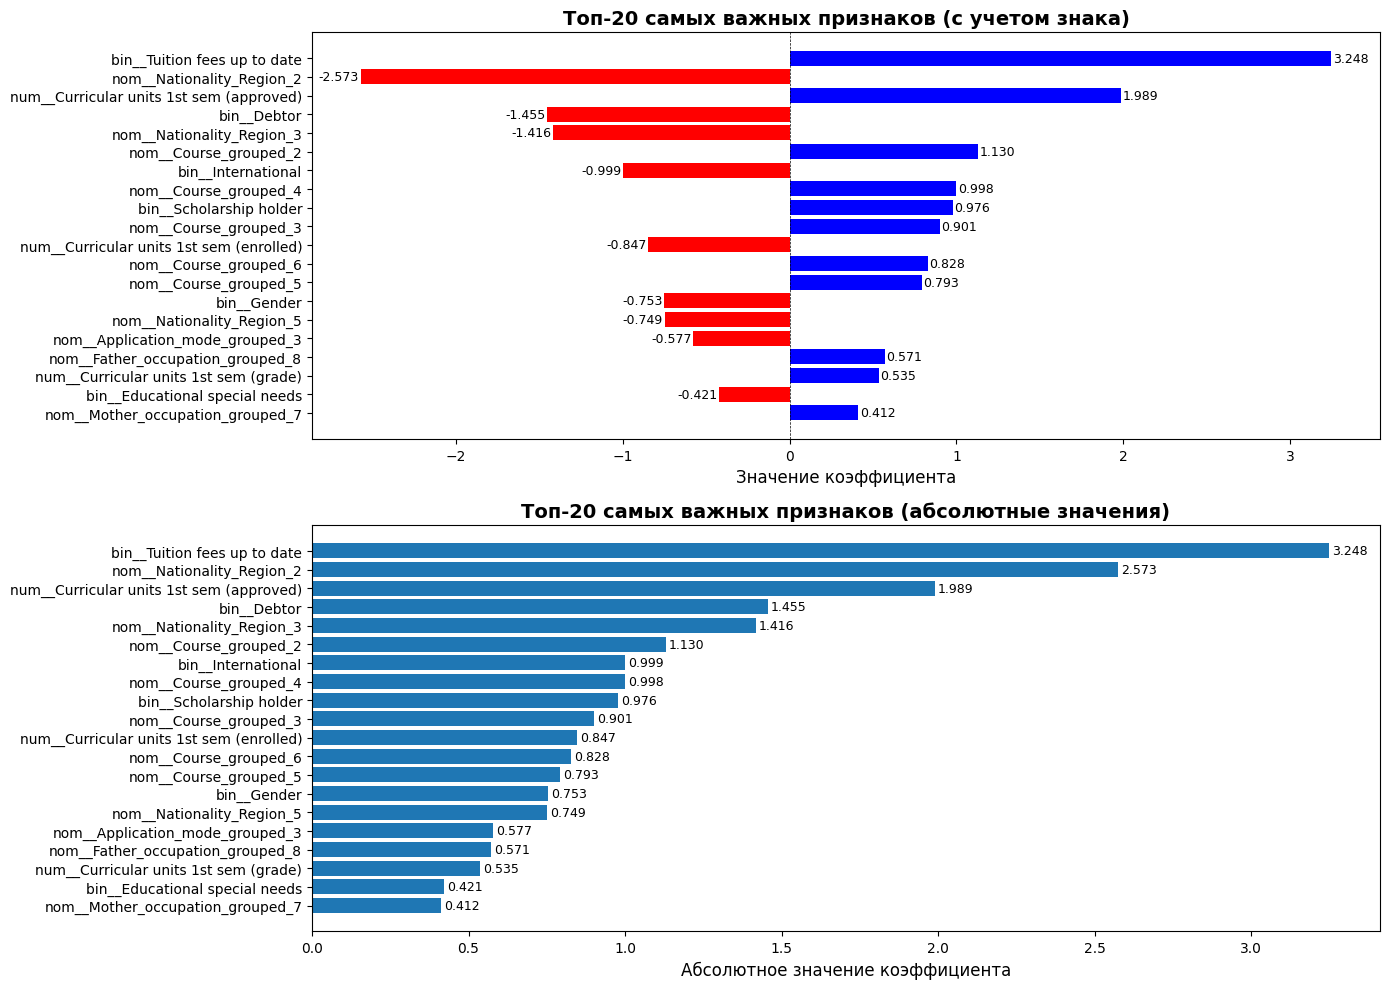

In [46]:
# Извлечение значимости признаков для логистической регрессии
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Извлекаем обученную модель и препроцессор
classifier = pipeline.named_steps['classifier']
preprocessor = pipeline.named_steps['preprocessor']

# 2. Получаем коэффициенты модели
# Для бинарной классификации coef_ имеет размер (1, n_features)
coefficients = classifier.coef_[0]

# 3. Получаем имена признаков после препроцессинга
try:
    # Для новых версий scikit-learn
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Для старых версий scikit-learn
    feature_names = []
    for name, transformer, features in preprocessor.transformers_:
        if name == 'nom':  # Для one-hot encoded признаков
            # Получаем категории для номинальных признаков
            nom_encoder = transformer
            for i, feature in enumerate(features):
                categories = nom_encoder.categories_[i][1:]  # исключаем первую категорию (drop='first')
                for cat in categories:
                    feature_names.append(f"{feature}_{cat}")
        elif hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(features))
        else:
            # Для passthrough или StandardScaler
            feature_names.extend(features)

# 4. Создаем DataFrame с важностью признаков
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# Сортируем по абсолютной важности
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

# 5. Визуализация
plt.figure(figsize=(14, 10))

# График 1: Топ-20 признаков с учетом знака
plt.subplot(2, 1, 1)
top_features = feature_importance.head(20)
colors = ['red' if coef < 0 else 'blue' for coef in top_features['coefficient']]
bars = plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Значение коэффициента', fontsize=12)
plt.title('Топ-20 самых важных признаков (с учетом знака)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis()

# Добавляем значения на график
for i, (coef, abs_coef) in enumerate(zip(top_features['coefficient'], top_features['abs_coefficient'])):
    plt.text(coef + (0.01 if coef >= 0 else -0.01), i, 
             f'{coef:.3f}', 
             ha='left' if coef >= 0 else 'right',
             va='center',
             fontsize=9)

# График 2: Абсолютные значения топ-20
plt.subplot(2, 1, 2)
bars = plt.barh(range(len(top_features)), top_features['abs_coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Абсолютное значение коэффициента', fontsize=12)
plt.title('Топ-20 самых важных признаков (абсолютные значения)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Добавляем значения на график
for i, val in enumerate(top_features['abs_coefficient']):
    plt.text(val + 0.01, i, f'{val:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Дерево решений

In [67]:
dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

In [68]:
def objective(trial, dt_pipeline, cv, recall_dropout_scorer):
    # Предлагаем гиперпараметры для Decision Tree
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    # Для class_weight используем разные стратегии (для 2 классов)
    class_weight_option = trial.suggest_categorical(
        'class_weight_option', 
        ['balanced', 'dropout_2', 'dropout_3', 'dropout_4', None]
    )
    
    # Преобразуем class_weight в нужный формат для 2 классов
    if class_weight_option == 'balanced':
        class_weight = 'balanced'
    elif class_weight_option == 'dropout_2':
        class_weight = {0: 2, 1: 1}  # Dropout весом 2, Graduate весом 1
    elif class_weight_option == 'dropout_3':
        class_weight = {0: 3, 1: 1}  # Dropout весом 3, Graduate весом 1
    elif class_weight_option == 'dropout_4':
        class_weight = {0: 4, 1: 1}  # Dropout весом 4, Graduate весом 1
    else:  # None
        class_weight = None
    
    # Дополнительные параметры (опционально)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    
    # Устанавливаем параметры в pipeline
    params = {
        'dt__max_depth': max_depth if max_depth < 30 else None,
        'dt__min_samples_split': min_samples_split,
        'dt__min_samples_leaf': min_samples_leaf,
        'dt__criterion': criterion,
        'dt__class_weight': class_weight,
        'dt__max_features': max_features,
        'dt__splitter': splitter,
    }
    
    dt_pipeline.set_params(**params)
    
    # Вычисляем скор с помощью кросс-валидации
    scores = cross_val_score(
        dt_pipeline, 
        X_train, 
        y_train,
        cv=cv,
        scoring=recall_dropout_scorer,
        n_jobs=-1
    )
    
    return scores.mean()

In [69]:
dt_study = optuna.create_study(
    direction='maximize',  # Мы хотим максимизировать recall для Dropout
    sampler=optuna.samplers.TPESampler(seed=42)
)

[I 2025-12-20 02:14:47,238] A new study created in memory with name: no-name-88b8b8d9-914b-41d7-9d31-b898db55bcf6


In [70]:
dt_study.optimize(
    lambda trial: objective(trial, dt_pipeline, cv, recall_dropout_scorer),
    n_trials=200,  # Количество испытаний
    show_progress_bar=True
)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-12-20 02:14:52,542] Trial 0 finished with value: 0.7799853076611588 and parameters: {'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 8, 'criterion': 'gini', 'class_weight_option': 'dropout_3', 'max_features': 'log2', 'splitter': 'best'}. Best is trial 0 with value: 0.7799853076611588.
[I 2025-12-20 02:14:54,684] Trial 1 finished with value: 0.7953056902353284 and parameters: {'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6, 'criterion': 'gini', 'class_weight_option': 'balanced', 'max_features': 'sqrt', 'splitter': 'best'}. Best is trial 1 with value: 0.7953056902353284.
[I 2025-12-20 02:14:56,542] Trial 2 finished with value: 0.7488621321092107 and parameters: {'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight_option': 'balanced', 'max_features': 'log2', 'splitter': 'best'}. Best is trial 1 with value: 0.7953056902353284.
[I 2025-12-20 02:14:56,749] Trial 3 finished with value: 0.7906387583898631 an

In [71]:
dt_best_params = dt_study.best_params
print("Лучшие параметры:", dt_best_params)
print("Лучший recall:", dt_study.best_value)

Лучшие параметры: {'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 10, 'criterion': 'gini', 'class_weight_option': 'dropout_4', 'max_features': None, 'splitter': 'random'}
Лучший recall: 0.836126239442121


In [82]:
pipeline_best_params = {}

for key, value in dt_best_params.items():
    if key == 'class_weight_option':
            pipeline_best_params[f'dt__class_weight'] = {0: 4, 1: 1}
    else:
        pipeline_best_params[f'dt__{key}'] = value

In [83]:
pipeline_best_params

{'dt__max_depth': 30,
 'dt__min_samples_split': 7,
 'dt__min_samples_leaf': 10,
 'dt__criterion': 'gini',
 'dt__class_weight': {0: 4, 1: 1},
 'dt__max_features': None,
 'dt__splitter': 'random'}

In [84]:
dt_pipeline.set_params(**pipeline_best_params)

,steps,"[('scaler', ...), ('dt', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,criterion,'gini'
,splitter,'random'
,max_depth,30
,min_samples_split,7


In [85]:
dt_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('dt', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,criterion,'gini'
,splitter,'random'
,max_depth,30
,min_samples_split,7


In [86]:
y_pred_dt = dt_pipeline.predict(X_test)

In [87]:
print("Оценка дерева решений на тестовых данных:")
print(f"Recall Dropout: {recall_dropout(y_test, y_pred_dt):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['Dropout', 'Enrolled']))

Оценка дерева решений на тестовых данных:
Recall Dropout: 0.8329
Accuracy: 0.8380

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.60      0.83      0.70      2088
    Enrolled       0.95      0.84      0.89      7147

    accuracy                           0.84      9235
   macro avg       0.77      0.84      0.79      9235
weighted avg       0.87      0.84      0.85      9235



# Случайный лес

In [60]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

In [61]:
def objective(trial, rf_pipeline, cv, recall_dropout_scorer):
    # Основные гиперпараметры Random Forest
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    
    # Для class_weight используем разные стратегии
    class_weight_option = trial.suggest_categorical(
        'class_weight_option', 
        ['balanced', 'balanced_subsample', 'dropout_2', 'dropout_3', 'dropout_4', None]
    )
    
    # Преобразуем class_weight в нужный формат
    if class_weight_option == 'balanced':
        class_weight = 'balanced'
    elif class_weight_option == 'balanced_subsample':
        class_weight = 'balanced_subsample'
    elif class_weight_option == 'dropout_2':
        class_weight = {0: 2, 1: 1}
    elif class_weight_option == 'dropout_3':
        class_weight = {0: 3, 1: 1}
    elif class_weight_option == 'dropout_4':
        class_weight = {0: 4, 1: 1}
    else:
        class_weight = None
    
    # Дополнительные параметры Random Forest
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    # Если bootstrap=True, можно настроить max_samples
    max_samples = None
    if bootstrap:
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0)
    
    # Устанавливаем параметры в pipeline
    params = {
        'rf__n_estimators': n_estimators,
        'rf__max_depth': max_depth if max_depth < 30 else None,
        'rf__min_samples_split': min_samples_split,
        'rf__min_samples_leaf': min_samples_leaf,
        'rf__criterion': criterion,
        'rf__class_weight': class_weight,
        'rf__max_features': max_features,
        'rf__bootstrap': bootstrap,
    }
    
    # Добавляем max_samples только если bootstrap=True
    if bootstrap and max_samples:
        params['rf__max_samples'] = max_samples
    else:
        params['rf__max_samples'] = None
    
    rf_pipeline.set_params(**params)
    
    # Вычисляем скор с помощью кросс-валидации
    scores = cross_val_score(
        rf_pipeline, 
        X_train, 
        y_train,
        cv=cv,
        scoring=recall_dropout_scorer,
        n_jobs=-1
    )
    
    return scores.mean()

In [62]:
rf_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

[I 2025-12-22 01:16:12,937] A new study created in memory with name: no-name-a9832d4c-4b22-4ac1-b73c-39edc9ebcefc


In [63]:
rf_study.optimize(
    lambda trial: objective(trial, rf_pipeline, cv, recall_dropout_scorer),
    n_trials=100,
    show_progress_bar=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-22 01:16:25,821] Trial 0 finished with value: 0.8126629326625027 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'criterion': 'gini', 'class_weight_option': 'dropout_4', 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8126629326625027.
[I 2025-12-22 01:16:45,765] Trial 1 finished with value: 0.790038379255851 and parameters: {'n_estimators': 273, 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 2, 'criterion': 'log_loss', 'class_weight_option': 'balanced', 'max_features': None, 'bootstrap': True, 'max_samples': 0.6523068845866853}. Best is trial 0 with value: 0.8126629326625027.
[I 2025-12-22 01:16:53,536] Trial 2 finished with value: 0.7712456594889217 and parameters: {'n_estimators': 139, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 2, 'criterion': 'log_loss', 'class_weight_option': 'balanced_subsample', 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0

In [64]:
rf_best_params = rf_study.best_params
print("Лучшие параметры Random Forest:", rf_best_params)
print("Лучший recall:", rf_study.best_value)

Лучшие параметры Random Forest: {'n_estimators': 366, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 9, 'criterion': 'gini', 'class_weight_option': 'dropout_4', 'max_features': 'log2', 'bootstrap': True, 'max_samples': 0.9983836422270871}
Лучший recall: 0.846780406870281


In [65]:
pipeline_best_params = {}

for key, value in rf_best_params.items():
    if key == 'class_weight_option':
            pipeline_best_params[f'rf__class_weight'] = {0: 4, 1: 1}
    else:
        pipeline_best_params[f'rf__{key}'] = value

In [66]:
pipeline_best_params

{'rf__n_estimators': 366,
 'rf__max_depth': 3,
 'rf__min_samples_split': 19,
 'rf__min_samples_leaf': 9,
 'rf__criterion': 'gini',
 'rf__class_weight': {0: 4, 1: 1},
 'rf__max_features': 'log2',
 'rf__bootstrap': True,
 'rf__max_samples': 0.9983836422270871}

In [67]:
rf_pipeline.set_params(**pipeline_best_params)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,366
,criterion,'gini'
,max_depth,3
,min_samples_split,19


In [68]:
rf_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,366
,criterion,'gini'
,max_depth,3
,min_samples_split,19


In [41]:
y_pred_rf = rf_pipeline.predict(X_test)

NameError: name 'rf_pipeline' is not defined

In [71]:
print("Оценка случайного леса на тестовых данных:")
print(f"Recall Dropout: {recall_dropout(y_test, y_pred_rf):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Dropout', 'Enrolled']))

Оценка случайного леса на тестовых данных:
Recall Dropout: 0.8314
Accuracy: 0.8510

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.63      0.83      0.72      2088
    Enrolled       0.95      0.86      0.90      7147

    accuracy                           0.85      9235
   macro avg       0.79      0.84      0.81      9235
weighted avg       0.87      0.85      0.86      9235



# XGBoost

In [106]:
def objective(trial):
    """
    Целевая функция для Optuna, максимизирующая recall для класса dropout
    """
    # Определяем гиперпараметры для оптимизации
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 11),  # randint(3, 12) -> 3-11 включительно
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.31),  # uniform(0.01, 0.3)
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # uniform(0.6, 0.4)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),  # uniform(0.6, 0.4)
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),  # uniform(0.5, 0.5)
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),  # uniform(0.5, 0.5)
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 3.0),  # uniform(0.5, 2.5)
        'n_estimators': trial.suggest_int('n_estimators', 300, 999),  # randint(300, 1000)
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.145, 0.435),  # uniform(0.29*0.5, 0.29*1.5)
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 9),  # randint(0, 10)
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 5.1),  # uniform(0.1, 5)
        'objective': 'binary:logistic',
        'random_state': 42,
        'eval_metric': ['mlogloss', 'merror']
    }
    
    # Создаем модель XGBoost
    model = xgb.XGBClassifier(**params)
    
    # Необязательно: можно добавить StandardScaler в пайплайн
    # Если ваши данные нуждаются в масштабировании
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', model)
    ])
    
    # Выполняем кросс-валидацию
    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring=recall_dropout_scorer,
        n_jobs=1  # XGBoost может конфликтовать с многопоточностью в кросс-валидации
    )
    
    # Возвращаем средний recall для dropout
    return np.mean(scores)

In [107]:
study = optuna.create_study(
    direction='maximize',  # Максимизируем recall для dropout
    study_name='xgboost_optuna',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=10,
        n_warmup_steps=5,
        interval_steps=1
    )
)

[I 2025-12-20 13:46:46,202] A new study created in memory with name: xgboost_optuna


In [108]:
study.optimize(objective, n_trials=150, show_progress_bar=True)

  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-12-20 13:46:55,999] Trial 0 finished with value: 0.7556846092375393 and parameters: {'max_depth': 6, 'learning_rate': 0.2952142919229748, 'subsample': 0.892797576724562, 'colsample_bytree': 0.8394633936788146, 'colsample_bylevel': 0.5780093202212182, 'colsample_bynode': 0.5779972601681014, 'reg_lambda': 0.6452090304204987, 'n_estimators': 906, 'scale_pos_weight': 0.31932335340553053, 'max_delta_step': 7, 'min_child_weight': 0.20292247147901224}. Best is trial 0 with value: 0.7556846092375393.
[I 2025-12-20 13:47:06,047] Trial 1 finished with value: 0.765860308109096 and parameters: {'max_depth': 11, 'learning_rate': 0.2597327922401265, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'colsample_bylevel': 0.5917022549267169, 'colsample_bynode': 0.6521211214797689, 'reg_lambda': 1.8118910790805947, 'n_estimators': 602, 'scale_pos_weight': 0.22945645065743214, 'max_delta_step': 6, 'min_child_weight': 0.7974693032602092}. Best is trial 1 with value: 0.765860

In [ ]:
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', model)
    ])

In [109]:
print(f"\nЛучшие параметры: {study.best_params}")
print(f"Лучший Recall 0-го класса: {study.best_value:.4f}")


Лучшие параметры: {'max_depth': 4, 'learning_rate': 0.03213369540055326, 'subsample': 0.7570008784811812, 'colsample_bytree': 0.6472982892867348, 'colsample_bylevel': 0.5399805582610183, 'colsample_bynode': 0.9494054279569839, 'reg_lambda': 2.8954139734404936, 'n_estimators': 336, 'scale_pos_weight': 0.1452806304588337, 'max_delta_step': 4, 'min_child_weight': 3.1029010373113204}
Лучший Recall 0-го класса: 0.8914


In [110]:
best_params = study.best_params

In [111]:
best_params

{'max_depth': 4,
 'learning_rate': 0.03213369540055326,
 'subsample': 0.7570008784811812,
 'colsample_bytree': 0.6472982892867348,
 'colsample_bylevel': 0.5399805582610183,
 'colsample_bynode': 0.9494054279569839,
 'reg_lambda': 2.8954139734404936,
 'n_estimators': 336,
 'scale_pos_weight': 0.1452806304588337,
 'max_delta_step': 4,
 'min_child_weight': 3.1029010373113204}

In [112]:
xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    random_state=42,
    eval_metric=['mlogloss', 'merror'],
    n_jobs=-1  # Используем все ядра
)

In [113]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb_model)
])

In [114]:
pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


In [115]:
y_pred_xgb = pipeline.predict(X_test)

In [116]:
print(f"Recall Dropout: {recall_dropout(y_test, y_pred_xgb):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Dropout', 'Graduate']))

Recall Dropout: 0.8736
Accuracy: 0.8390

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.60      0.87      0.71      2088
    Graduate       0.96      0.83      0.89      7147

    accuracy                           0.84      9235
   macro avg       0.78      0.85      0.80      9235
weighted avg       0.88      0.84      0.85      9235



# Без укрупнения

In [3]:
train = pd.read_csv('train.csv')

In [4]:
pd.set_option('display.max_columns', None)
train.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,18,0,0,6,6,6,14.500000,0,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,18,0,0,6,8,4,11.600000,0,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,19,2,3,144.7,0,0,0,1,1,0,18,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,3,3,2,126.1,1,0,0,1,0,1,18,0,0,7,9,7,12.591250,0,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,37,4,9,120.1,1,0,0,1,0,0,18,0,0,7,12,6,12.933333,0,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [5]:
label_encoder = LabelEncoder()
train['target_encoded'] = label_encoder.fit_transform(train['Target'])

print("Соответствие классов:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i} -> {class_name}")

Соответствие классов:
0 -> Dropout
1 -> Enrolled
2 -> Graduate


In [6]:
train_wout_2nd_sem = train.loc[:, ~train.columns.str.contains('2nd sem', case=False, na=False)]
train_wout_2nd_sem = train_wout_2nd_sem[train_wout_2nd_sem['Target'] != 'Enrolled']
train_wout_2nd_sem['target_encoded'] = train_wout_2nd_sem['target_encoded'].replace(2, 1)

In [7]:
df = train_wout_2nd_sem

In [8]:
target_distribution = df[df['Curricular units 1st sem (approved)'] == 0]['Target'].value_counts()

In [9]:
target_distribution

Target
Dropout     14854
Graduate      549
Name: count, dtype: int64

In [10]:
df = df[df['Curricular units 1st sem (approved)'] > 0]

## Логистическая регрессия

In [11]:
df_t = df.copy()

In [12]:
df_t

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,target_encoded
0,0,1,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,18,0,0,6,6,6,14.500000,0,11.1,0.6,2.02,Graduate,1
1,1,1,17,1,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,18,0,0,6,8,4,11.600000,0,11.1,0.6,2.02,Dropout,0
4,4,1,1,2,9500,1,1,132.0,1,19,37,4,9,120.1,1,0,0,1,0,0,18,0,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate,1
6,6,1,44,1,9085,1,39,130.0,1,37,37,9,6,130.0,1,0,0,1,0,0,21,0,0,5,7,4,12.750000,0,12.4,0.5,1.79,Graduate,1
7,7,1,1,1,9773,1,1,130.0,1,19,37,4,5,133.9,1,0,0,1,1,0,18,0,0,6,6,5,13.000000,0,10.8,1.4,1.74,Graduate,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76511,76511,1,17,1,9773,1,1,138.0,1,1,19,4,0,134.2,1,0,0,1,0,0,18,0,0,6,6,6,13.666667,0,12.4,0.5,1.79,Graduate,1
76512,76512,1,1,1,9238,1,1,134.0,1,19,38,4,7,122.1,1,0,0,1,0,0,19,0,0,6,6,6,12.666667,0,7.6,2.6,0.32,Graduate,1
76513,76513,1,17,1,9254,1,1,121.0,1,19,1,7,5,116.5,1,0,0,1,0,1,18,0,0,6,9,6,10.666667,0,13.9,-0.3,0.79,Graduate,1
76514,76514,1,1,6,9254,1,1,125.0,1,1,38,4,9,131.6,1,0,0,1,0,0,19,0,0,6,22,4,13.000000,0,9.4,-0.8,-3.12,Graduate,1


In [13]:
df_t = reduce_mem_usage(df_t)

Memory usage of dataframe is 11.98 MB
Memory usage after optimization is: 2.64 MB
Decreased by 77.9%


In [14]:
if 'target_encoded' not in df_t.columns:
    le = LabelEncoder()
    df_t['target_encoded'] = le.fit_transform(df_t['Target'])
    print(f"Target classes mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

In [15]:
X = df_t.drop(['Target', 'target_encoded'], axis=1, errors='ignore')
y = df_t['target_encoded'] if 'target_encoded' in df_t.columns else le.transform(df['Target'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [194]:
pipeline = Pipeline([
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced',
        penalty='l2',
        C=1.0,
        solver='lbfgs'
    ))
])

In [17]:
def recall_dropout(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=[0], average=None)[0]

recall_dropout_scorer = make_scorer(recall_dropout, greater_is_better=True)

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [197]:
def objective(trial, pipeline, cv, recall_dropout_scorer):
    # Предлагаем тип регуляризации
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
    # В зависимости от penalty выбираем допустимые solvers
    if penalty == 'l1':
        solver = trial.suggest_categorical('solver_l1', ['liblinear', 'saga'])
    elif penalty == 'l2':
        solver = trial.suggest_categorical('solver_l2', ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag'])
    else:  # elasticnet
        solver = 'saga'
        l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)
    
    # Остальные гиперпараметры
    C = trial.suggest_float('C', 1, 5, log=True)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    max_iter = trial.suggest_int('max_iter', 100, 2000)
    tol = trial.suggest_categorical('tol', [1e-4, 1e-3])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    
    # Устанавливаем параметры в pipeline
    params = {
        'classifier__C': C,
        'classifier__penalty': penalty,
        'classifier__solver': solver,
        'classifier__class_weight': class_weight,
        'classifier__max_iter': max_iter,
        'classifier__tol': tol,
        'classifier__fit_intercept': fit_intercept,
    }
    
    if penalty == 'elasticnet':
        params['classifier__l1_ratio'] = l1_ratio
    
    pipeline.set_params(**params)
    
    # Вычисляем скор с помощью кросс-валидации
    scores = cross_val_score(
        pipeline, 
        X_train,  # Нужно определить X_train и y_train
        y_train,
        cv=cv,
        scoring=recall_dropout_scorer,
        n_jobs=-1
    )
    
    return scores.mean()

In [198]:
study = optuna.create_study(
    direction='maximize',  # или 'minimize' в зависимости от метрики
    sampler=optuna.samplers.TPESampler(seed=42)
)

[I 2025-12-20 14:31:46,969] A new study created in memory with name: no-name-1b0aba79-08b4-4c99-b05a-73ea0e6d26b5


In [201]:
study.optimize(
    lambda trial: objective(trial, pipeline, cv, recall_dropout_scorer),
    n_trials=50,  # Количество испытаний
    show_progress_bar=True
)

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 14:35:07,036] Trial 9 finished with value: 0.0 and parameters: {'penalty': 'l1', 'solver_l1': 'saga', 'C': 1.682322118119185, 'class_weight': None, 'max_iter': 791, 'tol': 0.0001, 'fit_intercept': False}. Best is trial 7 with value: 0.8322946208122355.
[I 2025-12-20 14:35:10,664] Trial 10 finished with value: 0.7172597713012037 and parameters: {'penalty': 'l1', 'solver_l1': 'liblinear', 'C': 1.0863808535900512, 'class_weight': None, 'max_iter': 555, 'tol': 0.001, 'fit_intercept': True}. Best is trial 7 with value: 0.8322946208122355.
[I 2025-12-20 14:35:15,662] Trial 11 finished with value: 0.8295414198532918 and parameters: {'penalty': 'l2', 'solver_l2': 'liblinear', 'C': 1.156404680966883, 'class_weight': 'balanced', 'max_iter': 454, 'tol': 0.001, 'fit_intercept': True}. Best is trial 7 with value: 0.8322946208122355.
[I 2025-12-20 14:35:17,754] Trial 12 finished with value: 0.7180978079747149 and parameters: {'penalty': 'l1', 'solver_l1': 'liblinear', 'C': 3.6210716356

In [202]:
best_params = study.best_params
print("Лучшие параметры:", best_params)
print("Лучшее значение recall:", study.best_value)

Лучшие параметры: {'penalty': 'l1', 'solver_l1': 'liblinear', 'C': 4.393085259255232, 'class_weight': 'balanced', 'max_iter': 1667, 'tol': 0.0001, 'fit_intercept': True}
Лучшее значение recall: 0.8324143096213318


In [203]:
pipeline_best_params = {}

for key, value in best_params.items():
    pipeline_best_params[f'classifier__{key}'] = value

In [207]:
best_params = {
    'classifier__C': 4.367688611434853,
    'classifier__class_weight': 'balanced',
    'classifier__l1_ratio': 0.5740737821496418,
    'classifier__max_iter': 1539,
    'classifier__penalty': 'elasticnet',  # Для использования l1_ratio нужен penalty='elasticnet'
    'classifier__solver': 'saga',  # 'saga' поддерживает elasticnet
    'classifier__random_state': 42
}

In [208]:
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)

C:\Users\Данил\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,steps,"[('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,4.367688611434853
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'


In [63]:
y_pred = pipeline.predict(X_test)

In [209]:
recall_scores = recall_score(y_test, y_pred, average=None, labels=[0, 1])
print(f"Recall для Dropout (класс 0): {recall_scores[0]:.4f}")
print(f"Recall для Graduate (класс 1): {recall_scores[1]:.4f}")

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Dropout', 'Graduate']))

Recall для Dropout (класс 0): 0.8204
Recall для Graduate (класс 1): 0.9053
Accuracy: 0.8861
Classification Report:
              precision    recall  f1-score   support

     Dropout       0.72      0.82      0.77      2088
    Graduate       0.95      0.91      0.92      7147

    accuracy                           0.89      9235
   macro avg       0.83      0.86      0.84      9235
weighted avg       0.89      0.89      0.89      9235



## Дерево решений

In [210]:
dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

In [211]:
def objective(trial, dt_pipeline, cv, recall_dropout_scorer):
    # Предлагаем гиперпараметры для Decision Tree
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    # Для class_weight используем разные стратегии (для 2 классов)
    class_weight_option = trial.suggest_categorical(
        'class_weight_option', 
        ['balanced', 'dropout_2', 'dropout_3', 'dropout_4', None]
    )
    
    # Преобразуем class_weight в нужный формат для 2 классов
    if class_weight_option == 'balanced':
        class_weight = 'balanced'
    elif class_weight_option == 'dropout_2':
        class_weight = {0: 2, 1: 1}  # Dropout весом 2, Graduate весом 1
    elif class_weight_option == 'dropout_3':
        class_weight = {0: 3, 1: 1}  # Dropout весом 3, Graduate весом 1
    elif class_weight_option == 'dropout_4':
        class_weight = {0: 4, 1: 1}  # Dropout весом 4, Graduate весом 1
    else:  # None
        class_weight = None
    
    # Дополнительные параметры (опционально)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    
    # Устанавливаем параметры в pipeline
    params = {
        'dt__max_depth': max_depth if max_depth < 30 else None,
        'dt__min_samples_split': min_samples_split,
        'dt__min_samples_leaf': min_samples_leaf,
        'dt__criterion': criterion,
        'dt__class_weight': class_weight,
        'dt__max_features': max_features,
        'dt__splitter': splitter,
    }
    
    dt_pipeline.set_params(**params)
    
    # Вычисляем скор с помощью кросс-валидации
    scores = cross_val_score(
        dt_pipeline, 
        X_train, 
        y_train,
        cv=cv,
        scoring=recall_dropout_scorer,
        n_jobs=-1
    )
    
    return scores.mean()

In [212]:
dt_study = optuna.create_study(
    direction='maximize',  # Мы хотим максимизировать recall для Dropout
    sampler=optuna.samplers.TPESampler(seed=42)
)

[I 2025-12-20 14:56:58,053] A new study created in memory with name: no-name-0541d8d9-9552-46e4-9553-871f9ebcf8bd


In [214]:
dt_study.optimize(
    lambda trial: objective(trial, dt_pipeline, cv, recall_dropout_scorer),
    n_trials=200,  # Количество испытаний
    show_progress_bar=True
)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-12-20 14:57:27,848] Trial 31 finished with value: 0.8065589467384798 and parameters: {'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 5, 'criterion': 'gini', 'class_weight_option': 'dropout_4', 'max_features': None, 'splitter': 'best'}. Best is trial 22 with value: 0.8354058131492849.
[I 2025-12-20 14:57:30,218] Trial 32 finished with value: 0.8330142587356704 and parameters: {'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9, 'criterion': 'gini', 'class_weight_option': 'dropout_4', 'max_features': None, 'splitter': 'best'}. Best is trial 22 with value: 0.8354058131492849.
[I 2025-12-20 14:57:32,263] Trial 33 finished with value: 0.830499001996008 and parameters: {'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'gini', 'class_weight_option': 'dropout_4', 'max_features': None, 'splitter': 'best'}. Best is trial 22 with value: 0.8354058131492849.
[I 2025-12-20 14:57:32,535] Trial 34 finished with value: 0.8510892756676951 and

In [215]:
dt_best_params = dt_study.best_params
print("Лучшие параметры:", dt_best_params)
print("Лучший recall:", dt_study.best_value)

Лучшие параметры: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 8, 'criterion': 'gini', 'class_weight_option': 'dropout_4', 'max_features': None, 'splitter': 'best'}
Лучший recall: 0.8510892756676951


In [216]:
pipeline_best_params = {}

for key, value in dt_best_params.items():
    if key == 'class_weight_option':
            pipeline_best_params[f'dt__class_weight'] = {0: 4, 1: 1}
    else:
        pipeline_best_params[f'dt__{key}'] = value

In [217]:
pipeline_best_params

{'dt__max_depth': 4,
 'dt__min_samples_split': 6,
 'dt__min_samples_leaf': 8,
 'dt__criterion': 'gini',
 'dt__class_weight': {0: 4, 1: 1},
 'dt__max_features': None,
 'dt__splitter': 'best'}

In [218]:
dt_pipeline.set_params(**pipeline_best_params)

,steps,"[('scaler', ...), ('dt', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,6


In [219]:
dt_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('dt', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,6


In [220]:
y_pred_dt = dt_pipeline.predict(X_test)

In [221]:
print("Оценка дерева решений на тестовых данных:")
print(f"Recall Dropout: {recall_dropout(y_test, y_pred_dt):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['Dropout', 'Enrolled']))

Оценка дерева решений на тестовых данных:
Recall Dropout: 0.8376
Accuracy: 0.8264

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.58      0.84      0.69      2088
    Enrolled       0.95      0.82      0.88      7147

    accuracy                           0.83      9235
   macro avg       0.76      0.83      0.78      9235
weighted avg       0.86      0.83      0.84      9235



## Случайный лес

In [23]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

In [24]:
def objective(trial, rf_pipeline, cv, recall_dropout_scorer):
    # Основные гиперпараметры Random Forest
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    
    # Для class_weight используем разные стратегии
    class_weight_option = trial.suggest_categorical(
        'class_weight_option', 
        ['balanced', 'balanced_subsample', 'dropout_2', 'dropout_3', 'dropout_4', None]
    )
    
    # Преобразуем class_weight в нужный формат
    if class_weight_option == 'balanced':
        class_weight = 'balanced'
    elif class_weight_option == 'balanced_subsample':
        class_weight = 'balanced_subsample'
    elif class_weight_option == 'dropout_2':
        class_weight = {0: 2, 1: 1}
    elif class_weight_option == 'dropout_3':
        class_weight = {0: 3, 1: 1}
    elif class_weight_option == 'dropout_4':
        class_weight = {0: 4, 1: 1}
    else:
        class_weight = None
    
    # Дополнительные параметры Random Forest
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    # Если bootstrap=True, можно настроить max_samples
    max_samples = None
    if bootstrap:
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0)
    
    # Устанавливаем параметры в pipeline
    params = {
        'rf__n_estimators': n_estimators,
        'rf__max_depth': max_depth if max_depth < 30 else None,
        'rf__min_samples_split': min_samples_split,
        'rf__min_samples_leaf': min_samples_leaf,
        'rf__criterion': criterion,
        'rf__class_weight': class_weight,
        'rf__max_features': max_features,
        'rf__bootstrap': bootstrap,
    }
    
    # Добавляем max_samples только если bootstrap=True
    if bootstrap and max_samples:
        params['rf__max_samples'] = max_samples
    else:
        params['rf__max_samples'] = None
    
    rf_pipeline.set_params(**params)
    
    # Вычисляем скор с помощью кросс-валидации
    scores = cross_val_score(
        rf_pipeline, 
        X_train, 
        y_train,
        cv=cv,
        scoring=recall_dropout_scorer,
        n_jobs=-1
    )
    
    return scores.mean()

In [25]:
rf_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

[I 2025-12-22 00:23:57,745] A new study created in memory with name: no-name-f18cd002-4820-4d73-a206-1b1c16e0f8e4


In [26]:
rf_study.optimize(
    lambda trial: objective(trial, rf_pipeline, cv, recall_dropout_scorer),
    n_trials=100,
    show_progress_bar=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-22 00:24:10,087] Trial 0 finished with value: 0.8166132367222467 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'criterion': 'gini', 'class_weight_option': 'dropout_4', 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8166132367222467.
[I 2025-12-22 00:24:33,245] Trial 1 finished with value: 0.7853701573513655 and parameters: {'n_estimators': 273, 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 2, 'criterion': 'log_loss', 'class_weight_option': 'balanced', 'max_features': None, 'bootstrap': True, 'max_samples': 0.6523068845866853}. Best is trial 0 with value: 0.8166132367222467.
[I 2025-12-22 00:24:40,040] Trial 2 finished with value: 0.7689715721160909 and parameters: {'n_estimators': 139, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 2, 'criterion': 'log_loss', 'class_weight_option': 'balanced_subsample', 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 

In [28]:
rf_best_params = rf_study.best_params
print("Лучшие параметры Random Forest:", rf_best_params)
print("Лучший recall:", rf_study.best_value) 

Лучшие параметры Random Forest: {'n_estimators': 226, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 7, 'criterion': 'gini', 'class_weight_option': 'dropout_4', 'max_features': 'log2', 'bootstrap': True, 'max_samples': 0.7814741418522005}
Лучший recall: 0.8551595552163178


In [29]:
pipeline_best_params = {}

for key, value in rf_best_params.items():
    if key == 'class_weight_option':
            pipeline_best_params[f'rf__class_weight'] = {0: 4, 1: 1}
    else:
        pipeline_best_params[f'rf__{key}'] = value

In [30]:
pipeline_best_params

{'rf__n_estimators': 226,
 'rf__max_depth': 5,
 'rf__min_samples_split': 14,
 'rf__min_samples_leaf': 7,
 'rf__criterion': 'gini',
 'rf__class_weight': {0: 4, 1: 1},
 'rf__max_features': 'log2',
 'rf__bootstrap': True,
 'rf__max_samples': 0.7814741418522005}

In [31]:
rf_pipeline.set_params(**pipeline_best_params)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,226
,criterion,'gini'
,max_depth,5
,min_samples_split,14


In [32]:
rf_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,226
,criterion,'gini'
,max_depth,5
,min_samples_split,14


In [33]:
y_pred_rf = rf_pipeline.predict(X_test)

In [36]:
print("Оценка случайного леса на тестовых данных:")
print(f"Recall Dropout: {recall_dropout(y_test, y_pred_rf):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Dropout', 'Enrolled']))

Оценка случайного леса на тестовых данных:
Recall Dropout: 0.8386
Accuracy: 0.8544

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.63      0.84      0.72      2088
    Enrolled       0.95      0.86      0.90      7147

    accuracy                           0.85      9235
   macro avg       0.79      0.85      0.81      9235
weighted avg       0.88      0.85      0.86      9235



## XGBoost

In [19]:
def objective(trial):
    """
    Целевая функция для Optuna, максимизирующая recall для класса dropout
    """
    # Определяем гиперпараметры для оптимизации
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 11),  # randint(3, 12) -> 3-11 включительно
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.31),  # uniform(0.01, 0.3)
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # uniform(0.6, 0.4)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),  # uniform(0.6, 0.4)
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),  # uniform(0.5, 0.5)
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),  # uniform(0.5, 0.5)
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 3.0),  # uniform(0.5, 2.5)
        'n_estimators': trial.suggest_int('n_estimators', 300, 999),  # randint(300, 1000)
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.145, 0.435),  # uniform(0.29*0.5, 0.29*1.5)
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 9),  # randint(0, 10)
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 5.1),  # uniform(0.1, 5)
        'objective': 'binary:logistic',
        'random_state': 42,
        'eval_metric': ['mlogloss', 'merror']
    }
    
    # Создаем модель XGBoost
    model = xgb.XGBClassifier(**params)
    
    # Необязательно: можно добавить StandardScaler в пайплайн
    # Если ваши данные нуждаются в масштабировании
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', model)
    ])
    
    # Выполняем кросс-валидацию
    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring=recall_dropout_scorer,
        n_jobs=1  # XGBoost может конфликтовать с многопоточностью в кросс-валидации
    )
    
    # Возвращаем средний recall для dropout
    return np.mean(scores)

In [20]:
study = optuna.create_study(
    direction='maximize',  # Максимизируем recall для dropout
    study_name='xgboost_optuna',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=10,
        n_warmup_steps=5,
        interval_steps=1
    )
)

[I 2025-12-27 12:57:36,257] A new study created in memory with name: xgboost_optuna


In [21]:
study.optimize(objective, n_trials=150, show_progress_bar=True)

  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-12-27 12:58:01,381] Trial 0 finished with value: 0.7577192473222316 and parameters: {'max_depth': 6, 'learning_rate': 0.2952142919229748, 'subsample': 0.892797576724562, 'colsample_bytree': 0.8394633936788146, 'colsample_bylevel': 0.5780093202212182, 'colsample_bynode': 0.5779972601681014, 'reg_lambda': 0.6452090304204987, 'n_estimators': 906, 'scale_pos_weight': 0.31932335340553053, 'max_delta_step': 7, 'min_child_weight': 0.20292247147901224}. Best is trial 0 with value: 0.7577192473222316.
[I 2025-12-27 12:58:13,137] Trial 1 finished with value: 0.7640640442633584 and parameters: {'max_depth': 11, 'learning_rate': 0.2597327922401265, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'colsample_bylevel': 0.5917022549267169, 'colsample_bynode': 0.6521211214797689, 'reg_lambda': 1.8118910790805947, 'n_estimators': 602, 'scale_pos_weight': 0.22945645065743214, 'max_delta_step': 6, 'min_child_weight': 0.7974693032602092}. Best is trial 1 with value: 0.76406

In [22]:
print(f"\nЛучшие параметры: {study.best_params}")
print(f"Лучший Recall 0-го класса: {study.best_value:.4f}")


Лучшие параметры: {'max_depth': 3, 'learning_rate': 0.058032785971674154, 'subsample': 0.7264945647395824, 'colsample_bytree': 0.6152115692483144, 'colsample_bylevel': 0.6153299718690582, 'colsample_bynode': 0.6294536416954849, 'reg_lambda': 2.723280230750609, 'n_estimators': 475, 'scale_pos_weight': 0.14507728135830417, 'max_delta_step': 5, 'min_child_weight': 3.118170088182692}
Лучший Recall 0-го класса: 0.8994


In [23]:
best_params = study.best_params

In [24]:
best_params

{'max_depth': 3,
 'learning_rate': 0.058032785971674154,
 'subsample': 0.7264945647395824,
 'colsample_bytree': 0.6152115692483144,
 'colsample_bylevel': 0.6153299718690582,
 'colsample_bynode': 0.6294536416954849,
 'reg_lambda': 2.723280230750609,
 'n_estimators': 475,
 'scale_pos_weight': 0.14507728135830417,
 'max_delta_step': 5,
 'min_child_weight': 3.118170088182692}

In [25]:
xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    random_state=42,
    eval_metric=['mlogloss', 'merror'],
    n_jobs=-1  # Используем все ядра
)

In [26]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb_model)
])

In [27]:
pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


In [28]:
y_pred_xgb = pipeline.predict(X_test)

In [29]:
print(f"Recall Dropout: {recall_dropout(y_test, y_pred_xgb):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Dropout', 'Graduate']))

Recall Dropout: 0.8831
Accuracy: 0.8437

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.61      0.88      0.72      2088
    Graduate       0.96      0.83      0.89      7147

    accuracy                           0.84      9235
   macro avg       0.78      0.86      0.81      9235
weighted avg       0.88      0.84      0.85      9235



### Анализ важности признаков

Форма SHAP значений: (9235, 31)
Форма тестовых данных: (9235, 31)


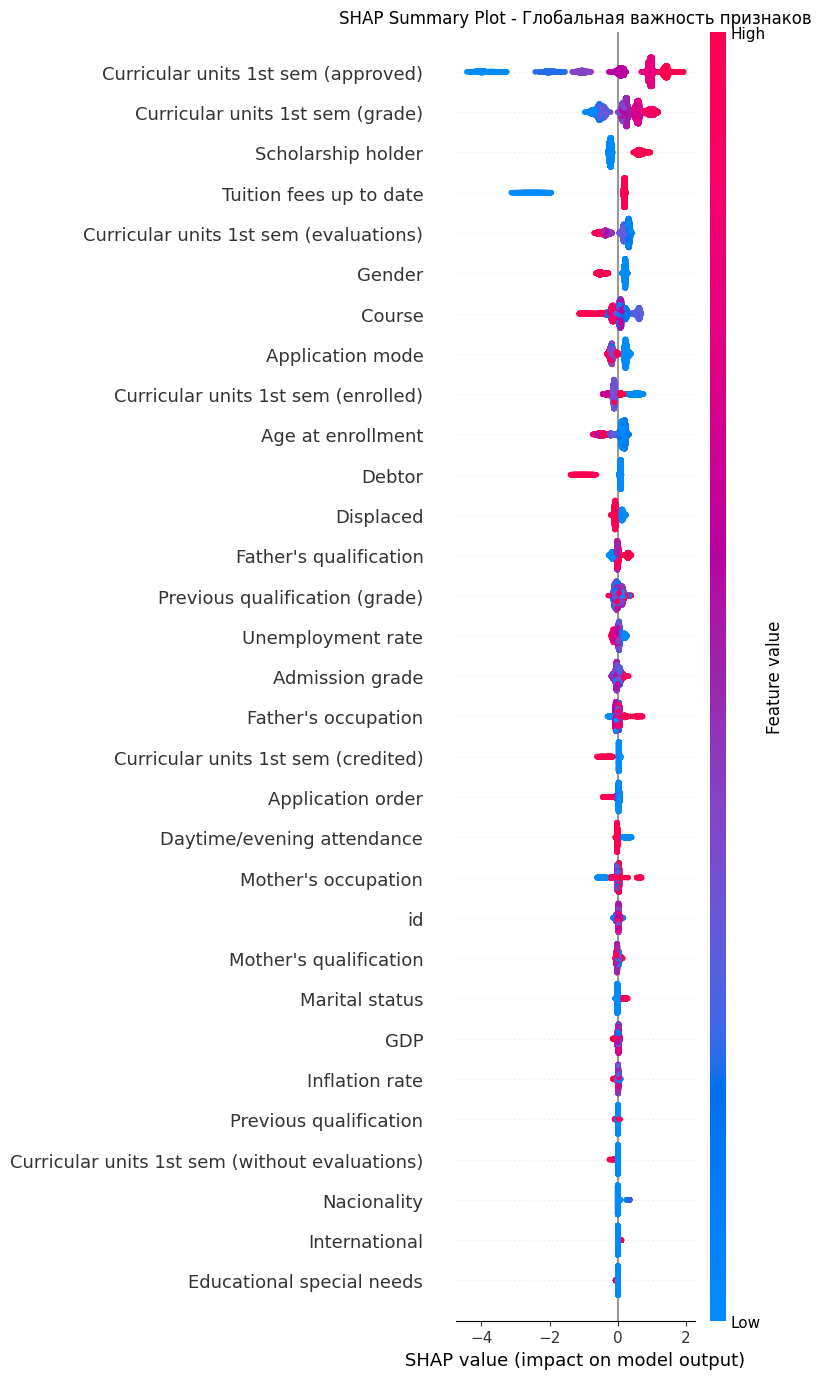

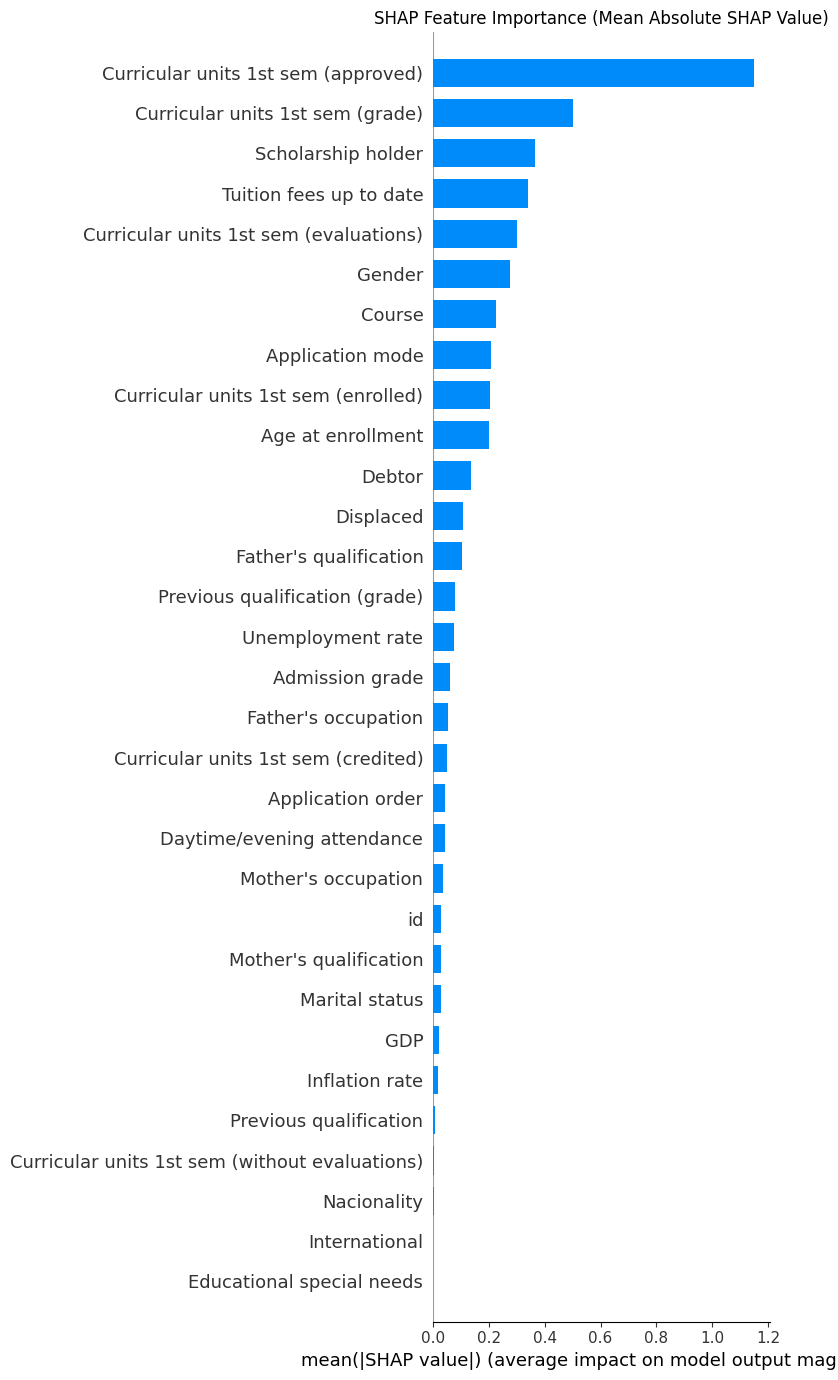

In [30]:
import shap

xgb_model = pipeline.named_steps['xgb']

X_train_scaled = pipeline.named_steps['scaler'].transform(X_train)
X_test_scaled = pipeline.named_steps['scaler'].transform(X_test)

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test_scaled)

print(f"Форма SHAP значений: {np.shape(shap_values)}")
print(f"Форма тестовых данных: {X_test_scaled.shape}")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns, show=False, max_display=len(X_train.columns))
plt.title("SHAP Summary Plot - Глобальная важность признаков")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns, plot_type="bar", show=False, max_display=len(X_train.columns))
plt.title("SHAP Feature Importance (Mean Absolute SHAP Value)")
plt.tight_layout()
plt.show()

In [31]:
columns_to_drop = [
    'Unemployment rate',
    'Admission grade',
    'Father\'s occupation',
    'Curricular units 1st sem (credited)',
    'Application order',
    'Daytime/evening attendance',
    'Mother\'s occupation',
    'id',
    'Mother\'s qualification',
    'Marital status',
    'GDP',
    'Inflation rate',
    'Previous qualification',
    'Curricular units 1st sem (without evaluations)',
    'Nacionality',
    'International',
    'Educational special needs'
]

In [32]:
X_train_selected = X_train.drop(columns=columns_to_drop, axis=1)

In [37]:
X_test_selected = X_test.drop(columns=columns_to_drop, axis=1)

In [33]:
xgb_model_selected = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    random_state=42,
    eval_metric=['mlogloss', 'merror'],
    n_jobs=-1  # Используем все ядра
)

In [34]:
pipeline_selected = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb_model)
])

In [35]:
pipeline_selected.fit(X_train_selected, y_train)

,steps,"[('scaler', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


In [39]:
y_pred_xgb_selected = pipeline_selected.predict(X_test_selected)

In [40]:
print(f"Recall Dropout: {recall_dropout(y_test, y_pred_xgb_selected):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_selected):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_selected, target_names=['Dropout', 'Graduate']))

Recall Dropout: 0.8779
Accuracy: 0.8398

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.60      0.88      0.71      2088
    Graduate       0.96      0.83      0.89      7147

    accuracy                           0.84      9235
   macro avg       0.78      0.85      0.80      9235
weighted avg       0.88      0.84      0.85      9235



Recall Dropout: 0.8831 -> Recall Dropout: 0.8779


Пробуем обрезать еще больше

In [41]:
columns_to_drop = [
    'Unemployment rate',
    'Admission grade',
    'Father\'s occupation',
    'Curricular units 1st sem (credited)',
    'Application order',
    'Daytime/evening attendance',
    'Mother\'s occupation',
    'id',
    'Mother\'s qualification',
    'Marital status',
    'GDP',
    'Inflation rate',
    'Previous qualification',
    'Curricular units 1st sem (without evaluations)',
    'Nacionality',
    'International',
    'Educational special needs',
    'Previous qualification (grade)',
    "Father's occupation",
    'Displaced',
    'Debtor'
]

In [42]:
X_train_selected = X_train.drop(columns=columns_to_drop, axis=1)

In [43]:
X_test_selected = X_test.drop(columns=columns_to_drop, axis=1)

In [44]:
xgb_model_selected = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    random_state=42,
    eval_metric=['mlogloss', 'merror'],
    n_jobs=-1  # Используем все ядра
)

In [45]:
pipeline_selected = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb_model)
])

In [46]:
pipeline_selected.fit(X_train_selected, y_train)

,steps,"[('scaler', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


In [47]:
y_pred_xgb_selected = pipeline_selected.predict(X_test_selected)

In [48]:
print(f"Recall Dropout: {recall_dropout(y_test, y_pred_xgb_selected):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_selected):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_selected, target_names=['Dropout', 'Graduate']))

Recall Dropout: 0.8774
Accuracy: 0.8306

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.58      0.88      0.70      2088
    Graduate       0.96      0.82      0.88      7147

    accuracy                           0.83      9235
   macro avg       0.77      0.85      0.79      9235
weighted avg       0.87      0.83      0.84      9235



Recall Dropout: 0.8831 -> Recall Dropout: 0.8779 -> Recall Dropout: 0.8774

Попробуем оставить только первые топ 5 признаков

In [61]:
top_5_features = [
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Scholarship holder',
    'Tuition fees up to date',
    'Curricular units 1st sem (evaluations)'
]

In [62]:
X_train_selected = X_train[top_5_features]
X_test_selected = X_test[top_5_features]

In [63]:
xgb_model_selected = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    random_state=42,
    eval_metric=['mlogloss', 'merror'],
    n_jobs=-1  # Используем все ядра
)

In [64]:
pipeline_selected = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb_model)
])

In [65]:
pipeline_selected.fit(X_train_selected, y_train)

,steps,"[('scaler', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


In [66]:
y_pred_xgb_selected = pipeline_selected.predict(X_test_selected)

In [67]:
print(f"Recall Dropout: {recall_dropout(y_test, y_pred_xgb_selected):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_selected):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_selected, target_names=['Dropout', 'Graduate']))

Recall Dropout: 0.8673
Accuracy: 0.8154

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.56      0.87      0.68      2088
    Graduate       0.95      0.80      0.87      7147

    accuracy                           0.82      9235
   macro avg       0.76      0.83      0.78      9235
weighted avg       0.86      0.82      0.83      9235



Recall Dropout: 0.8831 -> Recall Dropout: 0.8779 -> Recall Dropout: 0.8774 -> Recall Dropout: 0.8673